[Comprehensive molecular portraits of human breast tumours Nature 2012](https://www.nature.com/articles/nature11412)

[Comprehensive Molecular Portraits of Invasive Lobular Breast Cancer Cell 2015](https://www.sciencedirect.com/science/article/pii/S0092867415011952?via%3Dihub)

PAM50 the most clinical relevant prediction of subtype of breast cancer

These are TPM values

In [52]:
import sys
from time import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import umap

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn import mixture

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
# from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances
# from sklearn.isotonic import spearmanr
# from scipy.stats import pearsonr


import gdown

from itertools import permutations

# Configuration

umap_seed = 143
seed = 42
max_jobs = -1    # If the RAM gets used up in your case, modify it to reduce RAM usage
num_comp = 2
num_clusters = 5

In [53]:
path_expression = '/Users/zichenjiang/Downloads/TCGA BRCA BENG 285/TCGA.BRCA.expression.txt'
path_metadata = '/Users/zichenjiang/Downloads/TCGA BRCA BENG 285/TCGA.BRCA.metadata.txt'
# path_mutation = '../data/TCGA.BRCA.mutations.txt'

df_exp = pd.read_csv(path_expression, delimiter='\t')  # \s+ handles multiple spaces
df_meta = pd.read_csv(path_metadata, delimiter='\t')
# df_mut = pd.read_csv(path_mutation, delimiter='\t')
df_meta

patient_id  type  age_at_initial_pathologic_diagnosis  gender  \
0     TCGA-3C-AAAU  BRCA                                 55.0  FEMALE   
1     TCGA-3C-AALI  BRCA                                 50.0  FEMALE   
2     TCGA-3C-AALJ  BRCA                                 62.0  FEMALE   
3     TCGA-3C-AALK  BRCA                                 52.0  FEMALE   
4     TCGA-4H-AAAK  BRCA                                 50.0  FEMALE   
...            ...   ...                                  ...     ...   
1013  TCGA-WT-AB44  BRCA                                 77.0  FEMALE   
1014  TCGA-XX-A899  BRCA                                 46.0  FEMALE   
1015  TCGA-XX-A89A  BRCA                                 68.0  FEMALE   
1016  TCGA-Z7-A8R5  BRCA                                 61.0  FEMALE   
1017  TCGA-Z7-A8R6  BRCA                                 46.0  FEMALE   

                           race ajcc_pathologic_tumor_stage  \
0                         WHITE                     Stage X   
1     BLACK OR AFRICAN AMERICAN                   Stage IIB   
2     BLACK OR AFRICAN AMERICAN                   Stage IIB   
3     BLACK OR AFRICAN AMERICAN                    Stage IA   
4                         WHITE                  Stage IIIA   
...                         ...                         ...   
1013                      WHITE                    Stage IA   
1014                      WHITE                  Stage IIIA   
1015                      WHITE                   Stage IIB   
1016                      WHITE                  Stage IIIA   
1017                      WHITE                     Stage I   

                   histological_type histological_grade tumor_status  \
0     Infiltrating Lobular Carcinoma    [Not Available]   WITH TUMOR   
1      Infiltrating Ductal Carcinoma    [Not Available]   TUMOR FREE   
2      Infiltrating Ductal Carcinoma    [Not Available]   TUMOR FREE   
3      Infiltrating Ductal Carcinoma    [Not Available]   TUMOR FREE   
4     Infiltrating Lobular Carcinoma    [Not Available]   TUMOR FREE   
...                              ...                ...          ...   
1013  Infiltrating Lobular Carcinoma    [Not Available]   TUMOR FREE   
1014  Infiltrating Lobular Carcinoma    [Not Available]   TUMOR FREE   
1015  Infiltrating Lobular Carcinoma    [Not Available]   TUMOR FREE   
1016  Infiltrating Lobular Carcinoma    [Not Available]   WITH TUMOR   
1017  Infiltrating Lobular Carcinoma    [Not Available]   TUMOR FREE   

     vital_status   OS  OS.time  DSS  DSS.time  DFI  DFI.time  PFI  PFI.time  \
0           Alive  0.0   4047.0  0.0    4047.0  1.0    1808.0  1.0    1808.0   
1           Alive  0.0   4005.0  0.0    4005.0  0.0    4005.0  0.0    4005.0   
2           Alive  0.0   1474.0  0.0    1474.0  0.0    1474.0  0.0    1474.0   
3           Alive  0.0   1448.0  0.0    1448.0  NaN       NaN  0.0    1448.0   
4           Alive  0.0    348.0  0.0     348.0  0.0     348.0  0.0     348.0   
...           ...  ...      ...  ...       ...  ...       ...  ...       ...   
1013        Alive  0.0    883.0  0.0     883.0  0.0     883.0  0.0     883.0   
1014        Alive  0.0    467.0  0.0     467.0  0.0     467.0  0.0     467.0   
1015        Alive  0.0    488.0  0.0     488.0  0.0     488.0  0.0     488.0   
1016        Alive  0.0   3287.0  0.0    3287.0  NaN       NaN  1.0     181.0   
1017        Alive  0.0   3256.0  0.0    3256.0  0.0    3256.0  0.0    3256.0   

     Redaction  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
1013       NaN  
1014       NaN  
1015       NaN  
1016       NaN  
1017       NaN  

[1018 rows x 19 columns]

## 522 patients with PAM50 annotations from Nature 2012

In [54]:
# Load labels
# gdown.download('https://drive.google.com/uc?id=1iuSZx5-j8XaWLBKz08VAWw2EHdqEL5GM', 'tcga_pam50.tsv')
# data_raw = pd.read_csv('./tcga_pam50.tsv', sep='\t', skiprows=1)
# Filter out samples with missing labels
data_raw = pd.read_excel(
    'Supplementary Tables 1-4 PAM50 subtypes for 522 patients.xls',
    sheet_name=0,
    header=1,
)
data_raw["PAM50 mRNA"].value_counts()

PAM50 mRNA
Luminal A        231
Luminal B        127
Basal-like        98
HER2-enriched     58
Normal-like        8
Name: count, dtype: int64

## 514 patients from 4 major PAM50 subtypes

In [55]:
valid_labels = ["Basal-like", "HER2-enriched", "Luminal A", "Luminal B"] # "Normal-like" dropped because only 8 out of 522 (1.53%) patients
data = data_raw[data_raw['PAM50 mRNA'].isin(valid_labels)]
data

Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
0       TCGA-A2-A0T2  FEMALE                                 66.0  Negative   
1       TCGA-A2-A04P  FEMALE                                 36.0  Negative   
2       TCGA-A1-A0SK  FEMALE                                 54.0  Negative   
3       TCGA-A2-A0CM  FEMALE                                 40.0  Negative   
4       TCGA-AR-A1AR  FEMALE                                 50.0  Negative   
..               ...     ...                                  ...       ...   
509     TCGA-E2-A15K  FEMALE                                 58.0  Positive   
510     TCGA-E2-A15L  FEMALE                                 65.0  Positive   
511     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
512     TCGA-E2-A15S  FEMALE                                 34.0  Positive   
513     TCGA-E2-A15T  FEMALE                                 65.0  Positive   

    PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  ...  \
0    Negative          Negative    T3         T_Other   N3   Positive  ...   
1    Negative          Negative    T2         T_Other   N3   Positive  ...   
2    Negative          Negative    T2         T_Other   N0   Negative  ...   
3    Negative          Negative    T2         T_Other   N0   Negative  ...   
4    Negative          Negative    T1              T1   N2   Positive  ...   
..        ...               ...   ...             ...  ...        ...  ...   
509  Positive          Negative    T2         T_Other   N1   Positive  ...   
510  Positive          Negative    T2         T_Other   N0   Negative  ...   
511  Positive          Negative    T2         T_Other   N0   Negative  ...   
512  Negative          Negative    T2         T_Other   N1   Positive  ...   
513  Positive          Negative    T2         T_Other   N0   Negative  ...   

     PAM50 mRNA SigClust Unsupervised mRNA SigClust Intrinsic mRNA  \
0    Basal-like                        0.0                   -13.0   
1    Basal-like                        0.0                   -13.0   
2    Basal-like                       -6.0                   -13.0   
3    Basal-like                      -12.0                   -13.0   
4    Basal-like                        0.0                   -13.0   
..          ...                        ...                     ...   
509   Luminal B                       -3.0                   -12.0   
510   Luminal B                       -3.0                   -12.0   
511   Luminal B                       -4.0                    -4.0   
512   Luminal B                       -3.0                   -10.0   
513   Luminal B                       -3.0                   -10.0   

    miRNA Clusters methylation Clusters RPPA Clusters CN Clusters  \
0              3.0                  5.0         Basal         3.0   
1              5.0                  5.0         Basal         1.0   
2              5.0                  5.0         Basal         1.0   
3              4.0                  4.0         Basal         4.0   
4              5.0                  5.0           NaN         1.0   
..             ...                  ...           ...         ...   
509            4.0                  2.0          LumA         2.0   
510            NaN                  2.0         ReacI         2.0   
511            6.0                  1.0         ReacI         3.0   
512            6.0                  4.0        LumA/B         NaN   
513            2.0                  4.0        LumA/B         NaN   

     Integrated Clusters (with PAM50)  Integrated Clusters (no exp)  \
0                                 2.0                           2.0   
1                                 2.0                           2.0   
2                                 2.0                           2.0   
3                                 2.0                           1.0   
4                                 NaN                           NaN   
..                    

## 12 of these 514 patients in Nature 2012 are not in current GDC version of this cohort
Complete TCGA IDs not matched in df_meta:
['TCGA-B6-A0I6' 'TCGA-AO-A0JL' 'TCGA-A8-A07R' 'TCGA-A2-A0CY'
 'TCGA-BH-A1ES' 'TCGA-E2-A10E' 'TCGA-E2-A106' 'TCGA-AO-A12C'
 'TCGA-AQ-A04L' 'TCGA-A8-A08C' 'TCGA-A8-A07S' 'TCGA-E2-A14S']

In [56]:
# # Perform the merge with an indicator column
# data = data.merge(
#     df_meta,
#     left_on='Complete TCGA ID',
#     right_on='patient_id',
#     how='left',
#     indicator=True
# )

# # Extract the IDs from the left that had no match in df_meta
# unmatched_ids = data.loc[data['_merge'] == 'left_only', 'Complete TCGA ID'].unique()

# print("Complete TCGA IDs not matched in df_meta:")
# print(unmatched_ids)

data = data.merge(
    df_meta,
    left_on='Complete TCGA ID',
    right_on='patient_id',
    how='inner')
data


Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
0       TCGA-A2-A0T2  FEMALE                                 66.0  Negative   
1       TCGA-A2-A04P  FEMALE                                 36.0  Negative   
2       TCGA-A1-A0SK  FEMALE                                 54.0  Negative   
3       TCGA-A2-A0CM  FEMALE                                 40.0  Negative   
4       TCGA-AR-A1AR  FEMALE                                 50.0  Negative   
..               ...     ...                                  ...       ...   
497     TCGA-E2-A15K  FEMALE                                 58.0  Positive   
498     TCGA-E2-A15L  FEMALE                                 65.0  Positive   
499     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
500     TCGA-E2-A15S  FEMALE                                 34.0  Positive   
501     TCGA-E2-A15T  FEMALE                                 65.0  Positive   

    PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  ...  \
0    Negative          Negative    T3         T_Other   N3   Positive  ...   
1    Negative          Negative    T2         T_Other   N3   Positive  ...   
2    Negative          Negative    T2         T_Other   N0   Negative  ...   
3    Negative          Negative    T2         T_Other   N0   Negative  ...   
4    Negative          Negative    T1              T1   N2   Positive  ...   
..        ...               ...   ...             ...  ...        ...  ...   
497  Positive          Negative    T2         T_Other   N1   Positive  ...   
498  Positive          Negative    T2         T_Other   N0   Negative  ...   
499  Positive          Negative    T2         T_Other   N0   Negative  ...   
500  Negative          Negative    T2         T_Other   N1   Positive  ...   
501  Positive          Negative    T2         T_Other   N0   Negative  ...   

    vital_status   OS OS.time  DSS DSS.time  DFI DFI.time  PFI  PFI.time  \
0           Dead  1.0   255.0  1.0    255.0  NaN      NaN  1.0     255.0   
1           Dead  1.0   548.0  1.0    548.0  NaN      NaN  1.0     102.0   
2           Dead  1.0   967.0  1.0    967.0  NaN      NaN  1.0     967.0   
3           Dead  1.0   754.0  1.0    754.0  1.0    382.0  1.0     382.0   
4           Dead  1.0   524.0  1.0    524.0  1.0    268.0  1.0     268.0   
..           ...  ...     ...  ...      ...  ...      ...  ...       ...   
497        Alive  0.0   275.0  0.0    275.0  0.0    275.0  0.0     275.0   
498        Alive  0.0   626.0  0.0    626.0  0.0    626.0  0.0     626.0   
499         Dead  1.0   336.0  0.0    336.0  0.0    336.0  0.0     336.0   
500        Alive  0.0   428.0  0.0    428.0  0.0    428.0  0.0     428.0   
501        Alive  0.0  1563.0  0.0   1563.0  0.0   1563.0  0.0    1563.0   

     Redaction  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
497        NaN  
498        NaN  
499        NaN  
500        NaN  
501        NaN  

[502 rows x 49 columns]

In [57]:
data["Complete TCGA ID"].nunique(), data["patient_id"].nunique()

(502, 502)

In [58]:
data["PAM50 mRNA"].value_counts()

PAM50 mRNA
Luminal A        225
Luminal B        125
Basal-like        95
HER2-enriched     57
Name: count, dtype: int64

## Top 2 most clearly defined histological types will be used for embedding

In [59]:
data["histological_type"].value_counts()

histological_type
Infiltrating Ductal Carcinoma       427
Infiltrating Lobular Carcinoma       42
Other, specify                       19
Mixed Histology (please specify)     10
Mucinous Carcinoma                    2
Medullary Carcinoma                   1
[Not Available]                       1
Name: count, dtype: int64

## 469 patients

In [60]:
data = data[data["histological_type"].isin(["Infiltrating Ductal Carcinoma", "Infiltrating Lobular Carcinoma"])]
data

Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
0       TCGA-A2-A0T2  FEMALE                                 66.0  Negative   
1       TCGA-A2-A04P  FEMALE                                 36.0  Negative   
3       TCGA-A2-A0CM  FEMALE                                 40.0  Negative   
4       TCGA-AR-A1AR  FEMALE                                 50.0  Negative   
6       TCGA-BH-A1F0  FEMALE                                 80.0  Negative   
..               ...     ...                                  ...       ...   
497     TCGA-E2-A15K  FEMALE                                 58.0  Positive   
498     TCGA-E2-A15L  FEMALE                                 65.0  Positive   
499     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
500     TCGA-E2-A15S  FEMALE                                 34.0  Positive   
501     TCGA-E2-A15T  FEMALE                                 65.0  Positive   

         PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  \
0         Negative          Negative    T3         T_Other   N3   Positive   
1         Negative          Negative    T2         T_Other   N3   Positive   
3         Negative          Negative    T2         T_Other   N0   Negative   
4         Negative          Negative    T1              T1   N2   Positive   
6    Indeterminate          Negative    T1              T1   N1   Positive   
..             ...               ...   ...             ...  ...        ...   
497       Positive          Negative    T2         T_Other   N1   Positive   
498       Positive          Negative    T2         T_Other   N0   Negative   
499       Positive          Negative    T2         T_Other   N0   Negative   
500       Negative          Negative    T2         T_Other   N1   Positive   
501       Positive          Negative    T2         T_Other   N0   Negative   

     ... vital_status   OS OS.time  DSS DSS.time  DFI DFI.time  PFI  PFI.time  \
0    ...         Dead  1.0   255.0  1.0    255.0  NaN      NaN  1.0     255.0   
1    ...         Dead  1.0   548.0  1.0    548.0  NaN      NaN  1.0     102.0   
3    ...         Dead  1.0   754.0  1.0    754.0  1.0    382.0  1.0     382.0   
4    ...         Dead  1.0   524.0  1.0    524.0  1.0    268.0  1.0     268.0   
6    ...         Dead  1.0   785.0  1.0    785.0  NaN      NaN  1.0     785.0   
..   ...          ...  ...     ...  ...      ...  ...      ...  ...       ...   
497  ...        Alive  0.0   275.0  0.0    275.0  0.0    275.0  0.0     275.0   
498  ...        Alive  0.0   626.0  0.0    626.0  0.0    626.0  0.0     626.0   
499  ...         Dead  1.0   336.0  0.0    336.0  0.0    336.0  0.0     336.0   
500  ...        Alive  0.0   428.0  0.0    428.0  0.0    428.0  0.0     428.0   
501  ...        Alive  0.0  1563.0  0.0   1563.0  0.0   1563.0  0.0    1563.0   

     Redaction  
0          NaN  
1          NaN  
3          NaN  
4          NaN  
6          NaN  
..         ...  
497        NaN  
498        NaN  
499        NaN  
500        NaN  
501        NaN  

[469 rows x 49 columns]

In [61]:
data["Complete TCGA ID"].nunique(), data["patient_id"].nunique()

(469, 469)

In [62]:
#load data
df_exp = pd.read_csv(path_expression, delimiter='\t')  # \s+ handles multiple spaces
df_exp

patient_id                     sample_id  ?|100130426  ?|100133144  \
0     TCGA-3C-AAAU  TCGA-3C-AAAU-01A-11R-A41B-07       0.0000      16.3644   
1     TCGA-3C-AALI  TCGA-3C-AALI-01A-11R-A41B-07       0.0000       9.2659   
2     TCGA-3C-AALJ  TCGA-3C-AALJ-01A-31R-A41B-07       0.9066      11.6228   
3     TCGA-3C-AALK  TCGA-3C-AALK-01A-11R-A41B-07       0.0000      12.0894   
4     TCGA-4H-AAAK  TCGA-4H-AAAK-01A-12R-A41B-07       0.0000       6.8468   
...            ...                           ...          ...          ...   
1127  TCGA-WT-AB44  TCGA-WT-AB44-01A-11R-A41B-07       0.0000       0.0000   
1128  TCGA-XX-A899  TCGA-XX-A899-01A-11R-A36F-07       0.0000      14.3858   
1129  TCGA-XX-A89A  TCGA-XX-A89A-01A-11R-A36F-07       0.0000      22.3240   
1130  TCGA-Z7-A8R5  TCGA-Z7-A8R5-01A-42R-A41B-07       0.0000       2.2638   
1131  TCGA-Z7-A8R6  TCGA-Z7-A8R6-01A-11R-A41B-07       0.0000       6.8865   

      ?|100134869   ?|10357   ?|10431  ?|136542  ?|155060  ?|26823  ...  \
0         12.9316   52.1503   408.076       0.0  1187.010   0.0000  ...   
1         17.3790   69.7553   563.893       0.0   516.041   1.0875  ...   
2          9.2294  154.2970  1360.830       0.0   592.022   0.0000  ...   
3         11.0799  143.8640   865.536       0.0   552.751   0.4137  ...   
4         14.4298   84.2128   766.383       0.0   260.851   0.4255  ...   
...           ...       ...       ...       ...       ...      ...  ...   
1127       3.2580   42.2643  1877.420       0.0   704.541   4.0725  ...   
1128      21.4409  137.7760   652.756       0.0   427.165   2.7559  ...   
1129      27.2744   64.1427   722.721       0.0   376.476   0.4724  ...   
1130       7.2933   85.0461  1140.280       0.0   252.068   0.5973  ...   
1131      24.7795  167.5510  1003.570       0.0   238.017   0.3480  ...   

      ZWILCH|55055  ZWINT|11130  ZXDA|7789  ZXDB|158586  ZXDC|79364  \
0          415.824      931.957   129.5920     1007.780    1658.500   
1         1161.330      965.198    59.8151      448.613    1343.120   
2          305.422     2531.280    35.3581      533.998     768.812   
3          394.506      668.597    55.0269      437.733     863.881   
4          405.711      674.468    48.9362      424.255    1049.790   
...            ...          ...        ...          ...         ...   
1127       150.014      180.819    24.4349      243.535     772.959   
1128       456.047      457.087    70.8661      643.701    1266.540   
1129       530.198      694.379    48.6538      341.521    1375.530   
1130       173.109      258.639    32.2552      248.484     796.225   
1131       521.169     2435.840    34.4498      389.735     947.890   

      ZYG11A|440590  ZYG11B|79699  ZYX|7791  ZZEF1|23140  ZZZ3|26009  
0          258.4940      1208.370   3507.25     1894.930    1180.460  
1          198.4770       603.589   5504.62     1318.650     406.743  
2          331.8220       532.185   5458.75      942.883     509.519  
3          175.4240       607.365   5691.35      781.134     700.869  
4           14.0426       775.745   4041.70      831.915     881.702  
...             ...           ...       ...          ...         ...  
1127        98.5543       315.211  10937.10      800.652     443.087  
1128        21.2598       688.189   5118.11     1933.860     670.079  
1129       164.3840       746.812   5477.56     1437.410     953.708  
1130        51.9667       505.928   6675.63      754.413     750.829  
1131       139.5390       573.467   3402.52      564.419     462.114  

[1132 rows x 20533 columns]

In [63]:
# Keep only expression samples whose TCGA IDs match those in the filtered excel data.
common_ids = set(data["Complete TCGA ID"])
df_exp = df_exp[df_exp["patient_id"].isin(common_ids)]
df_exp

patient_id                     sample_id  ?|100130426  ?|100133144  \
9    TCGA-A1-A0SD  TCGA-A1-A0SD-01A-11R-A115-07          0.0       9.5178   
13   TCGA-A1-A0SH  TCGA-A1-A0SH-01A-11R-A084-07          0.0       1.6902   
15   TCGA-A1-A0SJ  TCGA-A1-A0SJ-01A-11R-A084-07          0.0       1.6424   
17   TCGA-A1-A0SM  TCGA-A1-A0SM-01A-11R-A084-07          0.0       6.5562   
19   TCGA-A1-A0SO  TCGA-A1-A0SO-01A-22R-A084-07          0.0      12.5687   
..            ...                           ...          ...          ...   
886  TCGA-E2-A1B5  TCGA-E2-A1B5-01A-21R-A12P-07          0.0       2.2834   
887  TCGA-E2-A1B6  TCGA-E2-A1B6-01A-31R-A12P-07          0.0       9.4801   
888  TCGA-E2-A1BC  TCGA-E2-A1BC-01A-11R-A12P-07          0.0       6.2212   
889  TCGA-E2-A1BC  TCGA-E2-A1BC-11A-32R-A12P-07          0.0       1.8406   
890  TCGA-E2-A1BD  TCGA-E2-A1BD-01A-11R-A12P-07          0.0       4.5596   

     ?|100134869   ?|10357   ?|10431  ?|136542  ?|155060  ?|26823  ...  \
9        11.3241   60.2630   977.918       0.0   83.6986   0.3308  ...   
13        3.0048   79.8003   989.197       0.0   95.7054   0.0000  ...   
15        4.9419  134.8730   765.981       0.0   63.6488   0.3658  ...   
17        7.6484  119.4760   831.124       0.0   80.8081   0.3157  ...   
19       21.4958  383.9290   669.936       0.0  143.0170   1.0814  ...   
..           ...       ...       ...       ...       ...      ...  ...   
886       1.5578   95.6039  1267.180       0.0   74.2638   0.0000  ...   
887      13.2776  138.3310  1974.340       0.0  235.6090   0.2231  ...   
888       7.3031   66.2609  1034.210       0.0   96.2609   0.7955  ...   
889       1.7264   74.1145   647.762       0.0  163.3670   0.7134  ...   
890       2.7378  146.7460  1138.900       0.0  246.8550   0.2516  ...   

     ZWILCH|55055  ZWINT|11130  ZXDA|7789  ZXDB|158586  ZXDC|79364  \
9        372.4460     648.7470    96.2700      578.281    1225.710   
13       402.1980     346.3450    87.7601      581.095     801.398   
15       354.8240     420.6680    83.7677     2731.410     834.385   
17       499.8550     505.0500    60.6061      546.086    1014.200   
19      1141.2800    1001.1200    71.6436      561.254     374.169   
..            ...          ...        ...          ...         ...   
886      351.8180     367.9040    42.2535      397.354     830.132   
887      611.0870    1178.4900    16.5105      253.905    1061.800   
888      337.8520     247.4150   103.4210     1278.440    1179.000   
889       61.8869      35.6697    63.4921      363.118    1250.580   
890      329.5140     665.8280    40.7650      405.133    1055.360   

     ZYG11A|440590  ZYG11B|79699  ZYX|7791  ZZEF1|23140  ZZZ3|26009  
9          33.0825       868.084   3559.67     1278.970    1195.600  
13         19.8634      1353.240   5464.96     1312.790    1001.120  
15         51.2117      1092.640   3032.10      958.390     718.793  
17         39.4571      1410.040   4570.08     1182.450    1454.860  
19        108.4120      1791.900   1341.22      821.063     897.844  
..             ...           ...       ...          ...         ...  
886       168.5870       822.450   2863.00      892.019     869.825  
887       194.1100       742.526   3321.95      867.916     780.009  
888        93.8743      1464.600   1774.86     1125.700    1349.240  
889         7.8473      1737.830   1889.78     1510.970     715.534  
890        53.3468       722.446   3278.31      955.964     663.312  

[533 rows x 20533 columns]

In [64]:
df_exp["patient_id"].nunique(), df_exp["sample_id"].nunique()

(469, 533)

## Merge meta data to expression in order to obtain labels for the expression

In [65]:
# df_exp = df_exp.drop_duplicates(subset="patient_id", keep="first")

merged_df = pd.merge(data, df_exp, left_on="Complete TCGA ID", right_on="patient_id", how="inner")
merged_df

Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
0       TCGA-A2-A0T2  FEMALE                                 66.0  Negative   
1       TCGA-A2-A04P  FEMALE                                 36.0  Negative   
2       TCGA-A2-A0CM  FEMALE                                 40.0  Negative   
3       TCGA-AR-A1AR  FEMALE                                 50.0  Negative   
4       TCGA-BH-A1F0  FEMALE                                 80.0  Negative   
..               ...     ...                                  ...       ...   
528     TCGA-E2-A15L  FEMALE                                 65.0  Positive   
529     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
530     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
531     TCGA-E2-A15S  FEMALE                                 34.0  Positive   
532     TCGA-E2-A15T  FEMALE                                 65.0  Positive   

         PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  \
0         Negative          Negative    T3         T_Other   N3   Positive   
1         Negative          Negative    T2         T_Other   N3   Positive   
2         Negative          Negative    T2         T_Other   N0   Negative   
3         Negative          Negative    T1              T1   N2   Positive   
4    Indeterminate          Negative    T1              T1   N1   Positive   
..             ...               ...   ...             ...  ...        ...   
528       Positive          Negative    T2         T_Other   N0   Negative   
529       Positive          Negative    T2         T_Other   N0   Negative   
530       Positive          Negative    T2         T_Other   N0   Negative   
531       Negative          Negative    T2         T_Other   N1   Positive   
532       Positive          Negative    T2         T_Other   N0   Negative   

     ... ZWILCH|55055 ZWINT|11130 ZXDA|7789 ZXDB|158586 ZXDC|79364  \
0    ...      400.704    655.3720   58.8498     327.240   1315.200   
1    ...      388.833   1194.5000   14.5228     178.942    887.967   
2    ...      933.795   1174.1100   51.2288     356.755   1058.270   
3    ...      699.365   1240.4800   48.4429     510.134   1156.200   
4    ...      630.476    584.1490   92.9132     631.896    907.194   
..   ...          ...         ...       ...         ...        ...   
528  ...      495.574   1285.5900   60.9299     958.928   1054.630   
529  ...      619.783    868.6060   82.0957     599.422    887.789   
530  ...      215.151     58.3975   85.0672     629.498   1100.820   
531  ...      633.076   2694.1800  108.1240    1077.500   2069.590   
532  ...      433.099    975.6100   95.3651     963.375   1550.310   

    ZYG11A|440590 ZYG11B|79699  ZYX|7791  ZZEF1|23140  ZZZ3|26009  
0        256.3530      999.554  5042.800      619.260     854.213  
1        214.2120      722.510  4314.830      686.722     686.722  
2        283.8350      662.744  4168.920     1016.270    1149.650  
3        195.2550     1891.990  3065.000     1109.990    1364.560  
4        149.6940     1560.810  3440.370     1358.000    1105.500  
..            ...          ...       ...          ...         ...  
528       12.4412      965.627  3609.860     1164.050     949.039  
529       83.5396     1204.410  1850.660     1219.270    1399.340  
530       43.2234     1248.880  6407.630     1431.430     830.440  
531      210.4960     1193.390   874.191     1525.230    7269.590  
532      210.4930     1081.950  1399.110      822.524    1145.010  

[533 rows x 20582 columns]

In [66]:
merged_df.columns[:70]

Index(['Complete TCGA ID', 'Gender', 'Age at Initial Pathologic Diagnosis',
       'ER Status', 'PR Status', 'HER2 Final Status', 'Tumor',
       'Tumor--T1 Coded', 'Node', 'Node-Coded', 'Metastasis',
       'Metastasis-Coded', 'AJCC Stage', 'Converted Stage',
       'Survival Data Form', 'Vital Status', 'Days to Date of Last Contact',
       'Days to date of Death', 'OS event', 'OS Time', 'PAM50 mRNA',
       'SigClust Unsupervised mRNA', 'SigClust Intrinsic mRNA',
       'miRNA Clusters', 'methylation Clusters', 'RPPA Clusters',
       'CN Clusters', 'Integrated Clusters (with PAM50)',
       'Integrated Clusters (no exp)', 'Integrated Clusters (unsup exp)',
       'patient_id_x', 'type', 'age_at_initial_pathologic_diagnosis', 'gender',
       'race', 'ajcc_pathologic_tumor_stage', 'histological_type',
       'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time',
       'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction',
       'patient_id_y', 'sampl

In [67]:
merged_df["Complete TCGA ID"].nunique(), merged_df["histological_type"].nunique()

(469, 2)

In [68]:
X = merged_df
X

Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
0       TCGA-A2-A0T2  FEMALE                                 66.0  Negative   
1       TCGA-A2-A04P  FEMALE                                 36.0  Negative   
2       TCGA-A2-A0CM  FEMALE                                 40.0  Negative   
3       TCGA-AR-A1AR  FEMALE                                 50.0  Negative   
4       TCGA-BH-A1F0  FEMALE                                 80.0  Negative   
..               ...     ...                                  ...       ...   
528     TCGA-E2-A15L  FEMALE                                 65.0  Positive   
529     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
530     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
531     TCGA-E2-A15S  FEMALE                                 34.0  Positive   
532     TCGA-E2-A15T  FEMALE                                 65.0  Positive   

         PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  \
0         Negative          Negative    T3         T_Other   N3   Positive   
1         Negative          Negative    T2         T_Other   N3   Positive   
2         Negative          Negative    T2         T_Other   N0   Negative   
3         Negative          Negative    T1              T1   N2   Positive   
4    Indeterminate          Negative    T1              T1   N1   Positive   
..             ...               ...   ...             ...  ...        ...   
528       Positive          Negative    T2         T_Other   N0   Negative   
529       Positive          Negative    T2         T_Other   N0   Negative   
530       Positive          Negative    T2         T_Other   N0   Negative   
531       Negative          Negative    T2         T_Other   N1   Positive   
532       Positive          Negative    T2         T_Other   N0   Negative   

     ... ZWILCH|55055 ZWINT|11130 ZXDA|7789 ZXDB|158586 ZXDC|79364  \
0    ...      400.704    655.3720   58.8498     327.240   1315.200   
1    ...      388.833   1194.5000   14.5228     178.942    887.967   
2    ...      933.795   1174.1100   51.2288     356.755   1058.270   
3    ...      699.365   1240.4800   48.4429     510.134   1156.200   
4    ...      630.476    584.1490   92.9132     631.896    907.194   
..   ...          ...         ...       ...         ...        ...   
528  ...      495.574   1285.5900   60.9299     958.928   1054.630   
529  ...      619.783    868.6060   82.0957     599.422    887.789   
530  ...      215.151     58.3975   85.0672     629.498   1100.820   
531  ...      633.076   2694.1800  108.1240    1077.500   2069.590   
532  ...      433.099    975.6100   95.3651     963.375   1550.310   

    ZYG11A|440590 ZYG11B|79699  ZYX|7791  ZZEF1|23140  ZZZ3|26009  
0        256.3530      999.554  5042.800      619.260     854.213  
1        214.2120      722.510  4314.830      686.722     686.722  
2        283.8350      662.744  4168.920     1016.270    1149.650  
3        195.2550     1891.990  3065.000     1109.990    1364.560  
4        149.6940     1560.810  3440.370     1358.000    1105.500  
..            ...          ...       ...          ...         ...  
528       12.4412      965.627  3609.860     1164.050     949.039  
529       83.5396     1204.410  1850.660     1219.270    1399.340  
530       43.2234     1248.880  6407.630     1431.430     830.440  
531      210.4960     1193.390   874.191     1525.230    7269.590  
532      210.4930     1081.950  1399.110      822.524    1145.010  

[533 rows x 20582 columns]

In [69]:
X.columns = [col.split('|')[0] for col in X.columns]
X

Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
0       TCGA-A2-A0T2  FEMALE                                 66.0  Negative   
1       TCGA-A2-A04P  FEMALE                                 36.0  Negative   
2       TCGA-A2-A0CM  FEMALE                                 40.0  Negative   
3       TCGA-AR-A1AR  FEMALE                                 50.0  Negative   
4       TCGA-BH-A1F0  FEMALE                                 80.0  Negative   
..               ...     ...                                  ...       ...   
528     TCGA-E2-A15L  FEMALE                                 65.0  Positive   
529     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
530     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
531     TCGA-E2-A15S  FEMALE                                 34.0  Positive   
532     TCGA-E2-A15T  FEMALE                                 65.0  Positive   

         PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  \
0         Negative          Negative    T3         T_Other   N3   Positive   
1         Negative          Negative    T2         T_Other   N3   Positive   
2         Negative          Negative    T2         T_Other   N0   Negative   
3         Negative          Negative    T1              T1   N2   Positive   
4    Indeterminate          Negative    T1              T1   N1   Positive   
..             ...               ...   ...             ...  ...        ...   
528       Positive          Negative    T2         T_Other   N0   Negative   
529       Positive          Negative    T2         T_Other   N0   Negative   
530       Positive          Negative    T2         T_Other   N0   Negative   
531       Negative          Negative    T2         T_Other   N1   Positive   
532       Positive          Negative    T2         T_Other   N0   Negative   

     ...   ZWILCH      ZWINT      ZXDA      ZXDB      ZXDC    ZYG11A  \
0    ...  400.704   655.3720   58.8498   327.240  1315.200  256.3530   
1    ...  388.833  1194.5000   14.5228   178.942   887.967  214.2120   
2    ...  933.795  1174.1100   51.2288   356.755  1058.270  283.8350   
3    ...  699.365  1240.4800   48.4429   510.134  1156.200  195.2550   
4    ...  630.476   584.1490   92.9132   631.896   907.194  149.6940   
..   ...      ...        ...       ...       ...       ...       ...   
528  ...  495.574  1285.5900   60.9299   958.928  1054.630   12.4412   
529  ...  619.783   868.6060   82.0957   599.422   887.789   83.5396   
530  ...  215.151    58.3975   85.0672   629.498  1100.820   43.2234   
531  ...  633.076  2694.1800  108.1240  1077.500  2069.590  210.4960   
532  ...  433.099   975.6100   95.3651   963.375  1550.310  210.4930   

       ZYG11B       ZYX     ZZEF1      ZZZ3  
0     999.554  5042.800   619.260   854.213  
1     722.510  4314.830   686.722   686.722  
2     662.744  4168.920  1016.270  1149.650  
3    1891.990  3065.000  1109.990  1364.560  
4    1560.810  3440.370  1358.000  1105.500  
..        ...       ...       ...       ...  
528   965.627  3609.860  1164.050   949.039  
529  1204.410  1850.660  1219.270  1399.340  
530  1248.880  6407.630  1431.430   830.440  
531  1193.390   874.191  1525.230  7269.590  
532  1081.950  1399.110   822.524  1145.010  

[533 rows x 20582 columns]

In [70]:
# 1) Set TCGA ID as index in X
X = X.set_index('Complete TCGA ID')

# 2) Select the PAM50 genes
pam50_genes = [
    "UBE2T", "BIRC5", "NUF2", "CDC6", "CCNB1", "TYMS", "MYBL2", "CEP55", "MELK", "NDC80",
    "RRM2", "UBE2C", "CENPF", "PTTG1", "EXO1", "ORC6L", "ANLN", "CCNE1", "CDC20", "MKI67",
    "KIF2C", "ACTR3B", "MYC", "EGFR", "KRT5", "PHGDH", "CDH3", "MIA", "KRT17", "FOXC1",
    "SFRP1", "KRT14", "ESR1", "SLC39A6", "BAG1", "MAPT", "PGR", "CXXC5", "MLPH", "BCL2",
    "MDM2", "NAT1", "FOXA1", "BLVRA", "MMP11", "GPR160", "FGFR4", "GRB7", "TMEM45B", "ERBB2"
]
common_genes = [g for g in pam50_genes if g in X.columns]
X = X[common_genes]

# 3) Filter merged_df to only those TCGA IDs present in X
merged_df_filtered_df = merged_df[merged_df['Complete TCGA ID'].isin(X.index)].copy()
merged_df_filtered_df


Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
0       TCGA-A2-A0T2  FEMALE                                 66.0  Negative   
1       TCGA-A2-A04P  FEMALE                                 36.0  Negative   
2       TCGA-A2-A0CM  FEMALE                                 40.0  Negative   
3       TCGA-AR-A1AR  FEMALE                                 50.0  Negative   
4       TCGA-BH-A1F0  FEMALE                                 80.0  Negative   
..               ...     ...                                  ...       ...   
528     TCGA-E2-A15L  FEMALE                                 65.0  Positive   
529     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
530     TCGA-E2-A15M  FEMALE                                 66.0  Positive   
531     TCGA-E2-A15S  FEMALE                                 34.0  Positive   
532     TCGA-E2-A15T  FEMALE                                 65.0  Positive   

         PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  \
0         Negative          Negative    T3         T_Other   N3   Positive   
1         Negative          Negative    T2         T_Other   N3   Positive   
2         Negative          Negative    T2         T_Other   N0   Negative   
3         Negative          Negative    T1              T1   N2   Positive   
4    Indeterminate          Negative    T1              T1   N1   Positive   
..             ...               ...   ...             ...  ...        ...   
528       Positive          Negative    T2         T_Other   N0   Negative   
529       Positive          Negative    T2         T_Other   N0   Negative   
530       Positive          Negative    T2         T_Other   N0   Negative   
531       Negative          Negative    T2         T_Other   N1   Positive   
532       Positive          Negative    T2         T_Other   N0   Negative   

     ...   ZWILCH      ZWINT      ZXDA      ZXDB      ZXDC    ZYG11A  \
0    ...  400.704   655.3720   58.8498   327.240  1315.200  256.3530   
1    ...  388.833  1194.5000   14.5228   178.942   887.967  214.2120   
2    ...  933.795  1174.1100   51.2288   356.755  1058.270  283.8350   
3    ...  699.365  1240.4800   48.4429   510.134  1156.200  195.2550   
4    ...  630.476   584.1490   92.9132   631.896   907.194  149.6940   
..   ...      ...        ...       ...       ...       ...       ...   
528  ...  495.574  1285.5900   60.9299   958.928  1054.630   12.4412   
529  ...  619.783   868.6060   82.0957   599.422   887.789   83.5396   
530  ...  215.151    58.3975   85.0672   629.498  1100.820   43.2234   
531  ...  633.076  2694.1800  108.1240  1077.500  2069.590  210.4960   
532  ...  433.099   975.6100   95.3651   963.375  1550.310  210.4930   

       ZYG11B       ZYX     ZZEF1      ZZZ3  
0     999.554  5042.800   619.260   854.213  
1     722.510  4314.830   686.722   686.722  
2     662.744  4168.920  1016.270  1149.650  
3    1891.990  3065.000  1109.990  1364.560  
4    1560.810  3440.370  1358.000  1105.500  
..        ...       ...       ...       ...  
528   965.627  3609.860  1164.050   949.039  
529  1204.410  1850.660  1219.270  1399.340  
530  1248.880  6407.630  1431.430   830.440  
531  1193.390   874.191  1525.230  7269.590  
532  1081.950  1399.110   822.524  1145.010  

[533 rows x 20582 columns]

In [71]:
merged_df_filtered_df.columns[:20]

Index(['Complete TCGA ID', 'Gender', 'Age at Initial Pathologic Diagnosis',
       'ER Status', 'PR Status', 'HER2 Final Status', 'Tumor',
       'Tumor--T1 Coded', 'Node', 'Node-Coded', 'Metastasis',
       'Metastasis-Coded', 'AJCC Stage', 'Converted Stage',
       'Survival Data Form', 'Vital Status', 'Days to Date of Last Contact',
       'Days to date of Death', 'OS event', 'OS Time'],
      dtype='object')

In [72]:
# 5) Extract PAM50 labels
y = merged_df_filtered_df["PAM50 mRNA"].values
X = X.values

In [73]:
X.shape, y.shape

((533, 50), (533,))

In [74]:
label_mapping = {subtype: idx for idx, subtype in enumerate(["Basal-like", "HER2-enriched", "Luminal A", "Luminal B", "Normal"])}
label_mapping

{'Basal-like': 0,
 'HER2-enriched': 1,
 'Luminal A': 2,
 'Luminal B': 3,
 'Normal': 4}

In [75]:
y_mapped = np.array([label_mapping[label] for label in y])
print(len(set(y_mapped)), "subtypes in primary samples with existing PAM50 labels from Nature 2012")
print(y_mapped)

4 subtypes in primary samples with existing PAM50 labels from Nature 2012
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3

In [76]:
# Apply log2 transformation with a pseudo-count of 1 to avoid log(0)
X = np.log2(X + 1)
# Apply robust normalization using RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [77]:
def pca_reduce(data_no_label,n_comp = num_comp):
  t0 = time()
  scaler = StandardScaler()
  data_scale = scaler.fit_transform(data_no_label)
  pca = PCA(n_components = n_comp)
  embedding_pca = pca.fit_transform(data_scale)
  t1 = time()
  #print('PCA running time is: ' + str(t1-t0) + ' s' )

  return embedding_pca


def mds_reduce(data_no_label,n_comp = num_comp,m_job = max_jobs):
  t0 = time()
  distance_matrix = pairwise_distances(data_no_label, metric='cosine')
  embedding_mds = MDS(n_components=n_comp, n_jobs=m_job, dissimilarity="precomputed").fit_transform(distance_matrix)
  t1 = time()
  #print('MDS running time is: ' + str(t1-t0) + ' s' )

  return embedding_mds


def tsne_reduce(data_no_label,n_comp = num_comp, r_seed = seed, m_job = max_jobs, grad = 'bh'):
  t0 = time()
  embedding_tsne = TSNE(n_components=n_comp, perplexity=90, random_state= r_seed, negative_gradient_method=grad).fit(data_no_label)
  t1 = time()
  #print('t-SNE running time is: ' + str(t1-t0) + ' s' )

  return embedding_tsne


def umap_reduce(data_no_label,n_comp = num_comp, measure='euclidean', r_seed = umap_seed, m_job = max_jobs):
  t0 = time()
  reducer = umap.UMAP(n_components=n_comp, metric=measure, random_state=r_seed)
  embedding_umap = reducer.fit_transform(data_no_label)
  t1 = time()
  #print('UMAP running time is: ' + str(t1-t0) + ' s' )

  return embedding_umap





In [78]:
def plot_embedding(embeddings, labels, title='UMAP'):
    fig, ax = plt.subplots()
    scatter = ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        c=[sns.color_palette("Set2", n_colors=5)[["LumA","LumB","Basal","Her2","Normal"].index(lbl)] for lbl in labels]
    )
    ax.set_title(title)
    plt.axis('on')
    plt.show()


# Grid search

In [79]:
# def evaluation(embedding, y, clustering_method, num_clusters = 5):
#     if clustering_method == 'kmeans':
#         cluster = KMeans(n_clusters=num_clusters, n_init=5, max_iter=100, random_state=42).fit_predict(embedding)
#     elif clustering_method == 'spectral':
#         cluster = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', n_neighbors=5, random_state=42).fit_predict(embedding)
#     elif clustering_method == 'agglomerative':
#         cluster = AgglomerativeClustering(n_clusters=num_clusters).fit_predict(embedding)
#     elif clustering_method == 'hdbscan':
#         distance_matrix = pairwise_distances(embedding, metric='cosine')
#         cluster = hdbscan.HDBSCAN(min_cluster_size=50).fit_predict(distance_matrix)
#     elif clustering_method == 'gmm':
#         cluster = mixture.GaussianMixture(n_components=num_clusters, max_iter=100, random_state=42).fit_predict(embedding)

#     # Evaluate clustering performance
#     # Adjusted Rand Index (ARI) - Good is close to 1 (-1,1)
#     # Normalized Mutual Information (NMI) - Good is close to 1 (0,1)
#     # Silhouette Score - Good is close to 1 (-1,1)
#     # Jaccard Score - Good is close to 1 (0,1)

#     # To account for the fact that clustering algorithms assign arbitrary numeric labels,
#     # we try all possible mappings between the unique predicted cluster labels and the unique true labels.
#     # This is done for all score metrics whose values can be sensitive to label assignments.
#     unique_pred = np.unique(cluster)
#     unique_true = np.unique(y)

#     best_ari = -1
#     best_nmi = -1
#     best_jaccard = -1
#     best_acc = -1

#     if len(unique_pred) <= len(unique_true):
#         for perm in permutations(unique_true, len(unique_pred)):
#             mapping = dict(zip(unique_pred, perm))
#             mapped_cluster = np.array([mapping[c] for c in cluster])
#             current_ari = adjusted_rand_score(y, mapped_cluster)
#             current_nmi = normalized_mutual_info_score(y, mapped_cluster)
#             current_jaccard = jaccard_score(y, mapped_cluster, average='weighted')
#             current_acc = np.mean(y == mapped_cluster)
#             if current_ari > best_ari:
#                 best_ari = current_ari
#             if current_nmi > best_nmi:
#                 best_nmi = current_nmi
#             if current_jaccard > best_jaccard:
#                 best_jaccard = current_jaccard
#             if current_acc > best_acc:
#                 best_acc = current_acc
#         ari, nmi, jaccard, acc = best_ari, best_nmi, best_jaccard, best_acc
#     else:
#         ari = adjusted_rand_score(y, cluster)
#         nmi = normalized_mutual_info_score(y, cluster)
#         jaccard = jaccard_score(y, cluster, average='weighted')
#         acc = np.mean(y == cluster)

#     # silhouette = silhouette_score(embedding, cluster)
#     # average_score = np.mean([ari, nmi, silhouette, jaccard, acc])
#     average_score = np.mean([ari, nmi, jaccard, acc])


#     # silhouette score is computed directly based on the embedding and cluster assignment
#     # silhouette = silhouette_score(embedding, cluster)

#     # norm_ari = (ari + 1) / 2
#     # norm_silhouette = (silhouette + 1) / 2
#     # average_score = np.mean([norm_ari, nmi, norm_silhouette, jaccard])
#     # average_score = np.mean([norm_ari, nmi, jaccard])
#     # return ari, nmi, silhouette, jaccard, acc, average_score
#     return ari, nmi, jaccard, acc, average_score

In [80]:
# def create_embeddings(n_comp = 2):
#     return  {
#         'PCA': pca_reduce(X, n_comp=n_comp),
#         'MDS': mds_reduce(X , n_comp=n_comp ),
#         't-SNE': tsne_reduce(X, n_comp=n_comp),
#         'UMAP': umap_reduce(X, n_comp=n_comp)
#     }


In [81]:
# # --- clustering methods and grids ---
# clustering_methods = ['kmeans','spectral','agglomerative','hdbscan','gmm']

# pca_params = {
#     'n_components': [2,3,4,5],
#     'svd_solver':   ['covariance_eigh','randomized','full'],
#     'tol':          [0.0,1e-4,1e-3],
# }
# mds_params = {
#     'n_components': [2,3,4,5],
#     'metric':       [True,False],
#     'n_init':       [4,8,10],
#     'max_iter':     [300,500,1000],
# }
# tsne_params = {
#     'n_components':   [2,3,4,5],
#     'perplexity':     [5,10,30],
#     'learning_rate':  ['auto',100,500],
#     'early_exaggeration':   [6,12,24],
# }
# umap_params = {
#     'n_components': [2,3,4,5],
#     'n_neighbors':  [5, 8, 10, 15, 20],
#     'min_dist':     [0.001,0.01,0.1],
#     'init':         ['spectral', 'pca', 'random'],
#     'metric':       ['euclidean', 'canberra', 'cosine', 'correlation'],
# }

# # pre‐compute for speed
# # scaled_X    = StandardScaler().fit_transform(X)
# dist_matrix = pairwise_distances(X) # X is already robust scalled

# # collect records
# records = []

# for method, grid, embed_fn in [
#     ('PCA',  pca_params,  lambda X,p: PCA(**p).fit_transform(X)),
#     ('MDS',  mds_params,  lambda X,p: MDS(**{**p,'dissimilarity':'precomputed'},
#                                             n_jobs=max_jobs,random_state=seed
#                                            ).fit_transform(dist_matrix)),
#     ('t-SNE', tsne_params, lambda X,p: TSNE(**p, method='exact',
#                                             random_state=seed
#                                            ).fit_transform(X)),
#     ('UMAP', umap_params, lambda X,p: umap.UMAP(**p, random_state=seed).fit_transform(X)),
# ]:
#     print(f'Running {method}...')

#     for params in ParameterGrid(grid):
#         emb = embed_fn(X, params)

#         for cm in clustering_methods:
#             ari, nmi, jaccard, acc, avg = evaluation(emb, y_mapped, cm, num_clusters=num_clusters)
#             records.append({
#                 'method':         method,
#                 'parameters':      params,
#                 'n_components':   params['n_components'],
#                 'clustering':     cm,
#                 'average_score':  avg
#             })

In [82]:
# df = pd.DataFrame(records)
# df

In [83]:
# df.to_csv('../output/tables/469_patients_533_samples_no_Normal_like_patients_and_patients_of_two_histological_subtypes_PAM50_genes_robustscaler_4_reduction_methods_parameter_search_5_clustering_methods_default_4_metrics.csv', index=False)

In [84]:
# X.shape, y.shape, df.shape

In [106]:
df = pd.read_csv('./469_patients_533_samples_no_Normal_like_patients_and_patients_of_two_histological_subtypes_PAM50_genes_robustscaler_4_reduction_methods_parameter_search_5_clustering_methods_default_4_metrics.csv')
df

method                                         parameters  n_components  \
0       PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
1       PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
2       PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
3       PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
4       PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
...     ...                                                ...           ...   
4675   UMAP  {'init': 'random', 'metric': 'correlation', 'm...             5   
4676   UMAP  {'init': 'random', 'metric': 'correlation', 'm...             5   
4677   UMAP  {'init': 'random', 'metric': 'correlation', 'm...             5   
4678   UMAP  {'init': 'random', 'metric': 'correlation', 'm...             5   
4679   UMAP  {'init': 'random', 'metric': 'correlation', 'm...             5   

         clustering  average_score  
0            kmeans       0.196929  
1          spectral       0.348748  
2     agglomerative       0.315297  
3           hdbscan       0.409203  
4               gmm       0.247407  
...             ...            ...  
4675         kmeans       0.318611  
4676       spectral       0.104534  
4677  agglomerative       0.288734  
4678        hdbscan       0.404241  
4679            gmm       0.311990  

[4680 rows x 5 columns]

In [86]:
# Aggregate duplicates
df_best_parameter_of_each_method_each_clustering = (
    df
    .groupby(['method','n_components','clustering'])['average_score']
    .max()
    .reset_index()
)
df_best_parameter_of_each_method_each_clustering


method  n_components     clustering  average_score
0     MDS             2  agglomerative       0.254933
1     MDS             2            gmm       0.286719
2     MDS             2        hdbscan       0.353993
3     MDS             2         kmeans       0.374569
4     MDS             2       spectral       0.237285
..    ...           ...            ...            ...
75  t-SNE             5  agglomerative       0.408615
76  t-SNE             5            gmm       0.293839
77  t-SNE             5        hdbscan       0.418302
78  t-SNE             5         kmeans       0.348572
79  t-SNE             5       spectral       0.369722

[80 rows x 4 columns]

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_98392/3190990842.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


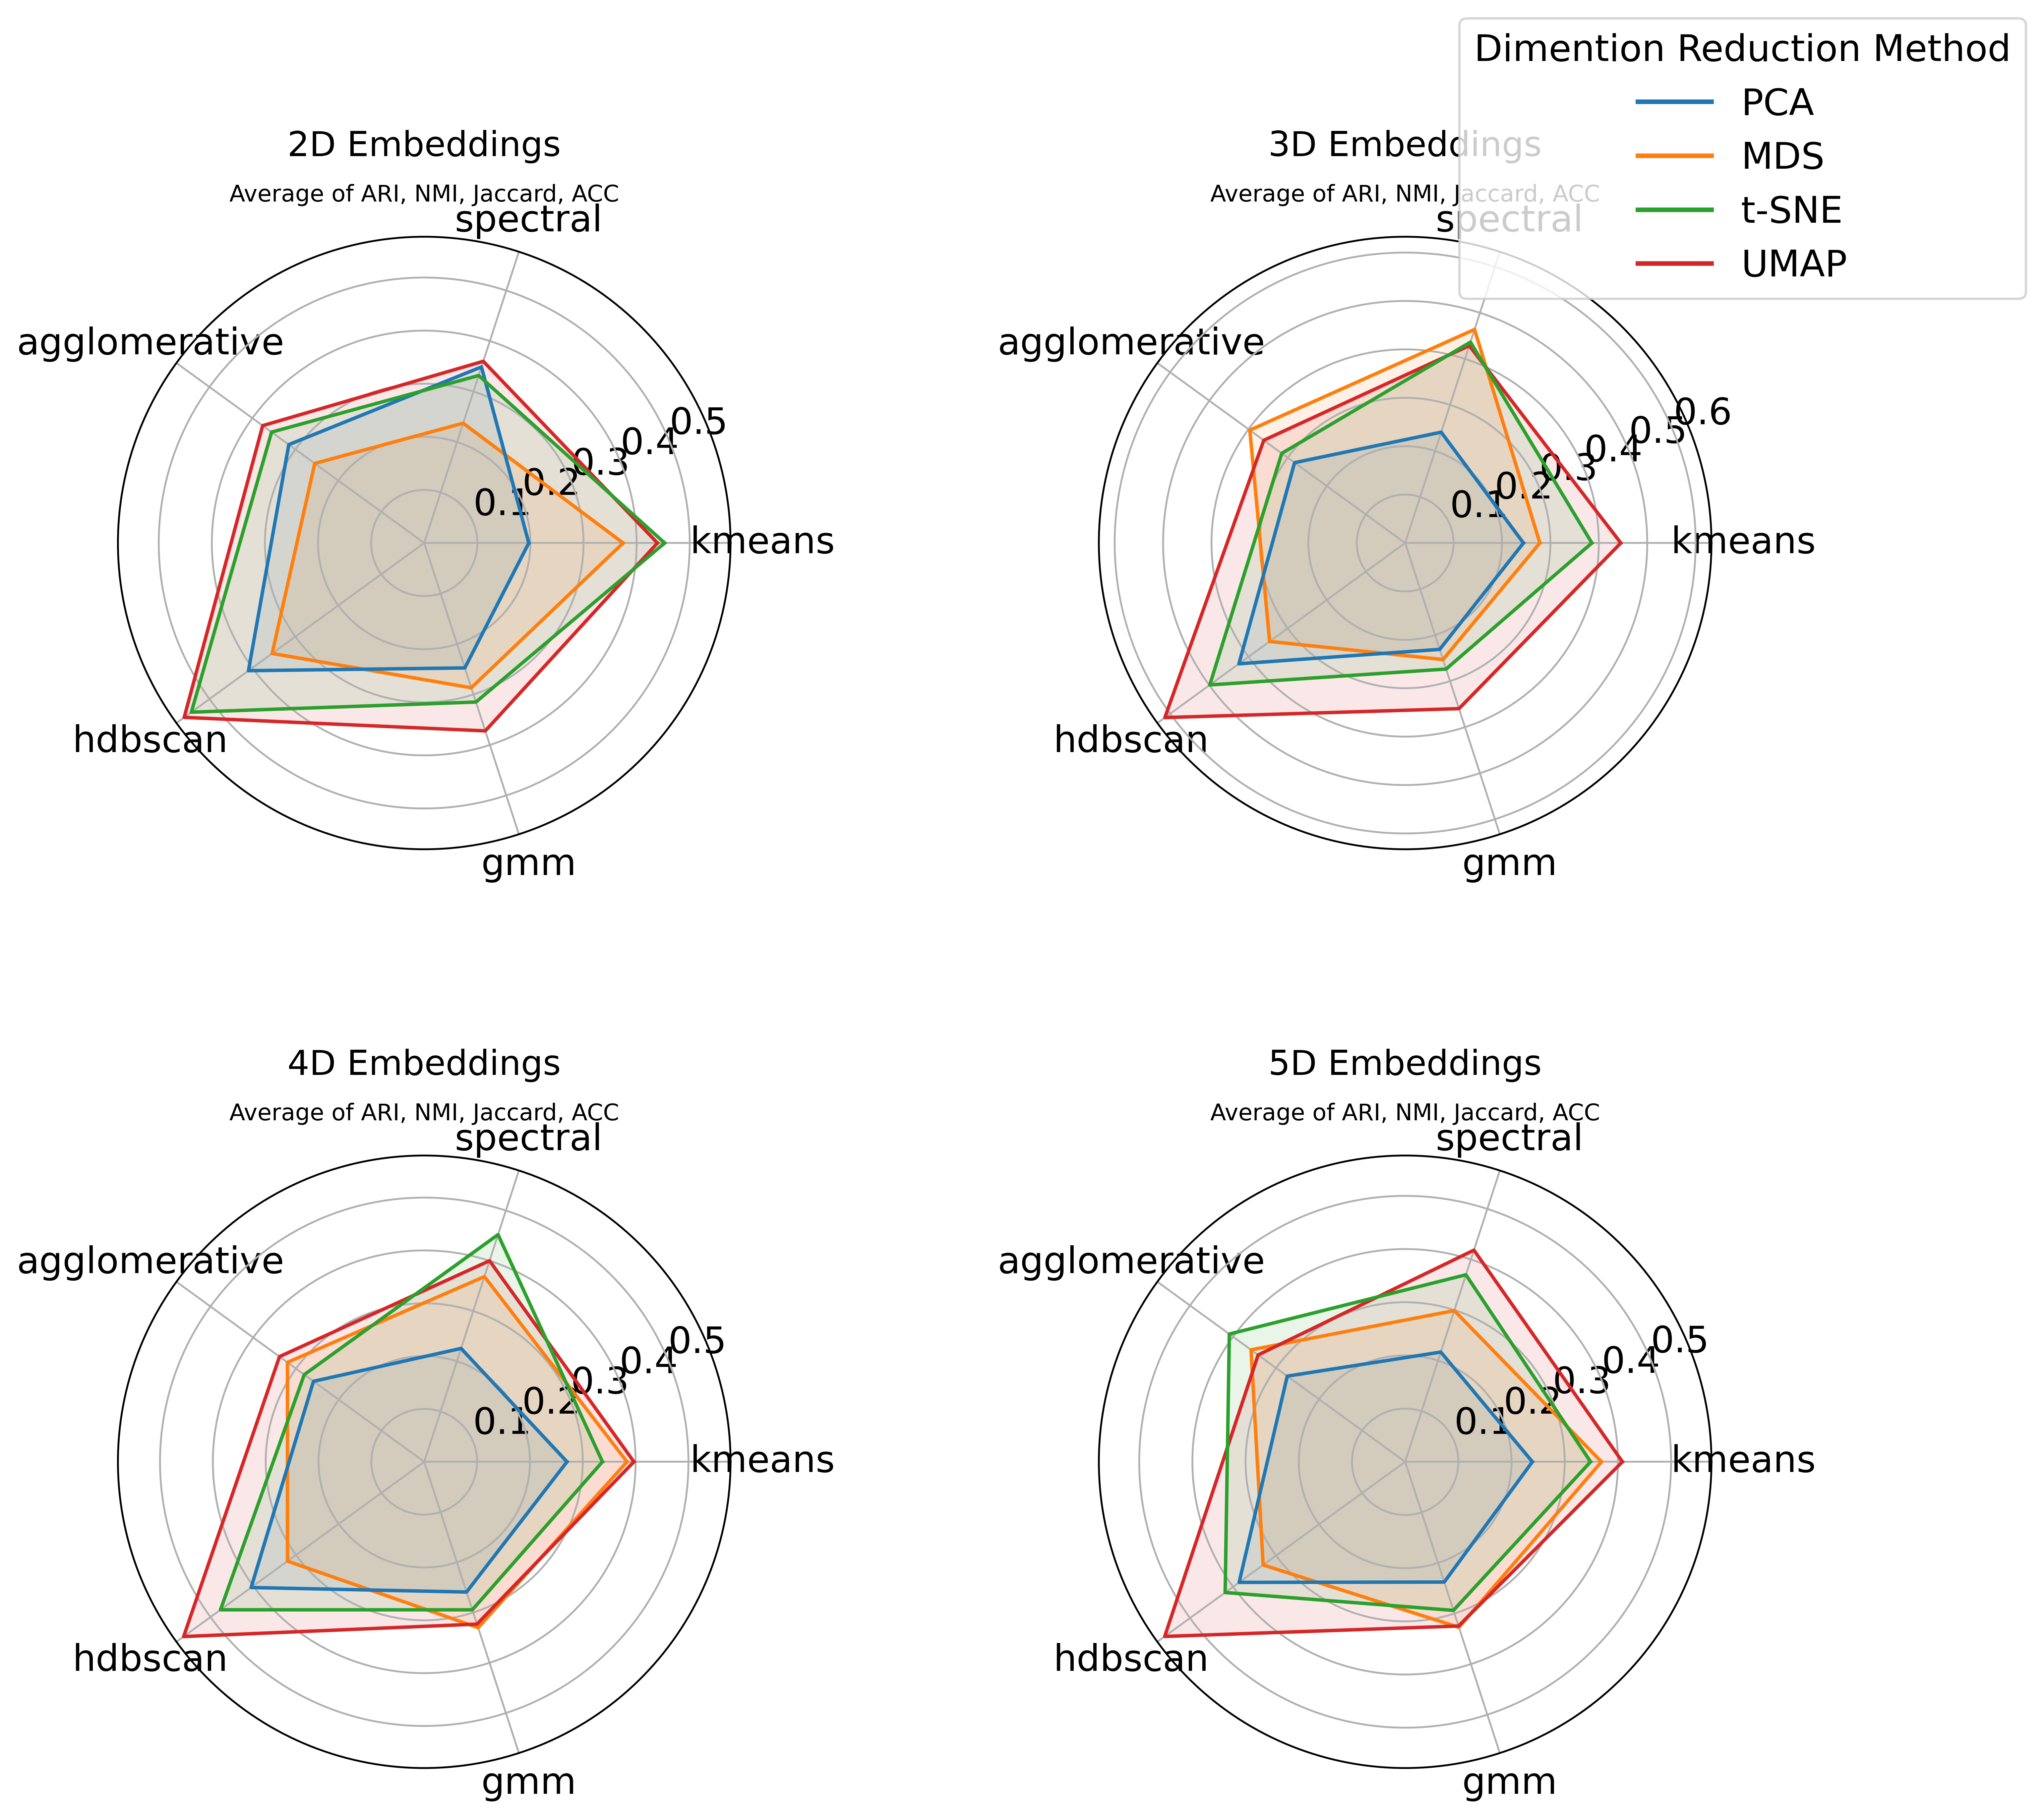

In [87]:
clustering = ['kmeans', 'spectral', 'agglomerative', 'hdbscan', 'gmm']
angles = np.linspace(0, 2*np.pi, len(clustering), endpoint=False).tolist()
angles += angles[:1]

methods = df_best_parameter_of_each_method_each_clustering['method'].unique()
n_comps = sorted(df_best_parameter_of_each_method_each_clustering['n_components'].unique())

# color mapping
color_map = {
    'PCA':    'tab:blue',
    'MDS':    'tab:orange',
    't-SNE':  'tab:green',
    'UMAP':   'tab:red'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 12), dpi=500, subplot_kw=dict(polar=True), gridspec_kw={'hspace': 0.5})
axes = axes.flatten()

for idx, comp in enumerate(n_comps):
    ax = axes[idx]
    sub = df_best_parameter_of_each_method_each_clustering[df_best_parameter_of_each_method_each_clustering['n_components']==comp]
    pivot = sub.pivot(index='method', columns='clustering', values='average_score')
    for meth in methods:
        vals = pivot.loc[meth, clustering].tolist()
        vals += vals[:1]
        c = color_map[meth]
        ax.plot(angles, vals, label=meth, color=c)
        ax.fill(angles, vals, color=c, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(clustering)
    ax.set_title(f"{comp}D Embeddings", fontsize=15, pad=35)
    ax.text(0.5, 1.05, "Average of ARI, NMI, Jaccard, ACC",
            transform=ax.transAxes, fontsize=10, ha='center', va='bottom')

# custom legend
legend_elements = [
    Line2D([0], [0], color=color_map['PCA'],   lw=2, label='PCA'),
    Line2D([0], [0], color=color_map['MDS'],   lw=2, label='MDS'),
    Line2D([0], [0], color=color_map['t-SNE'], lw=2, label='t-SNE'),
    Line2D([0], [0], color=color_map['UMAP'],  lw=2, label='UMAP'),
]
fig.legend(handles=legend_elements,
           loc='upper right',
           title="Dimention Reduction Method")

plt.tight_layout()
# plt.savefig("../output/figures/469_patients_533_samples_no_Normal_like_patients_and_patients_of_two_histological_subtypes_PAM50_genes_robustscaler_4_reduction_methods_parameter_search_5_clustering_methods_default_4_metrics_radar_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [88]:
df_best_parameter_of_each_method_each_clustering

method  n_components     clustering  average_score
0     MDS             2  agglomerative       0.254933
1     MDS             2            gmm       0.286719
2     MDS             2        hdbscan       0.353993
3     MDS             2         kmeans       0.374569
4     MDS             2       spectral       0.237285
..    ...           ...            ...            ...
75  t-SNE             5  agglomerative       0.408615
76  t-SNE             5            gmm       0.293839
77  t-SNE             5        hdbscan       0.418302
78  t-SNE             5         kmeans       0.348572
79  t-SNE             5       spectral       0.369722

[80 rows x 4 columns]

In [89]:
# 1) Maximum average_score per method
best_scores = (
    df_best_parameter_of_each_method_each_clustering.loc[df_best_parameter_of_each_method_each_clustering['n_components'].isin([2, 3])]
    .groupby('method')['average_score']
    .max()
    .reset_index(name='max_average_score')
)
best_scores

method  max_average_score
0    MDS           0.463894
1    PCA           0.424528
2   UMAP           0.613567
3  t-SNE           0.542165

In [90]:
# 2) Full best‐row per method
idx = (
    df_best_parameter_of_each_method_each_clustering.loc[df_best_parameter_of_each_method_each_clustering['n_components'].isin([2, 3])]
    .groupby('method')['average_score']
    .idxmax()
)
best_params_per_method = (
    df_best_parameter_of_each_method_each_clustering.loc[df_best_parameter_of_each_method_each_clustering['n_components'].isin([2, 3])]
    .loc[idx]
    .reset_index(drop=True)
)
best_params_per_method

method  n_components clustering  average_score
0    MDS             3   spectral       0.463894
1    PCA             3    hdbscan       0.424528
2   UMAP             3    hdbscan       0.613567
3  t-SNE             2    hdbscan       0.542165

In [91]:
# # Boolean mask where each row’s average_score equals the max for its method
# mask = df['average_score'] == df.groupby('method')['average_score'].transform('max')

# # Select those rows
# best_rows = df[mask]
# best_rows

In [92]:
# Restrict to n_components 2 or 3
df23 = df[df['n_components'].isin([2, 3])]

# Boolean mask where each row’s average_score equals the per‐method max within the 2/3 subset
mask = df23['average_score'] == df23.groupby('method')['average_score'].transform('max')

# Select those rows
best_rows = df23[mask]
best_rows

method                                         parameters  n_components  \
48      PCA  {'n_components': 3, 'svd_solver': 'covariance_...             3   
53      PCA  {'n_components': 3, 'svd_solver': 'covariance_...             3   
58      PCA  {'n_components': 3, 'svd_solver': 'covariance_...             3   
63      PCA  {'n_components': 3, 'svd_solver': 'randomized'...             3   
68      PCA  {'n_components': 3, 'svd_solver': 'randomized'...             3   
73      PCA  {'n_components': 3, 'svd_solver': 'randomized'...             3   
78      PCA  {'n_components': 3, 'svd_solver': 'full', 'tol...             3   
83      PCA  {'n_components': 3, 'svd_solver': 'full', 'tol...             3   
88      PCA  {'n_components': 3, 'svd_solver': 'full', 'tol...             3   
316     MDS  {'max_iter': 500, 'metric': True, 'n_component...             3   
436     MDS  {'max_iter': 1000, 'metric': True, 'n_componen...             3   
793   t-SNE  {'early_exaggeration': 12, 'learning_rate': 10...             2   
3823   UMAP  {'init': 'random', 'metric': 'canberra', 'min_...             3   

     clustering  average_score  
48      hdbscan       0.424528  
53      hdbscan       0.424528  
58      hdbscan       0.424528  
63      hdbscan       0.424528  
68      hdbscan       0.424528  
73      hdbscan       0.424528  
78      hdbscan       0.424528  
83      hdbscan       0.424528  
88      hdbscan       0.424528  
316    spectral       0.463894  
436    spectral       0.463894  
793     hdbscan       0.542165  
3823    hdbscan       0.613567

In [93]:
print(best_rows[best_rows["method"] == "UMAP"]["parameters"].iloc[0])

{'init': 'random', 'metric': 'canberra', 'min_dist': 0.001, 'n_components': 3, 'n_neighbors': 15}


# Visualize 3D using matplotlib or Plotly

/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


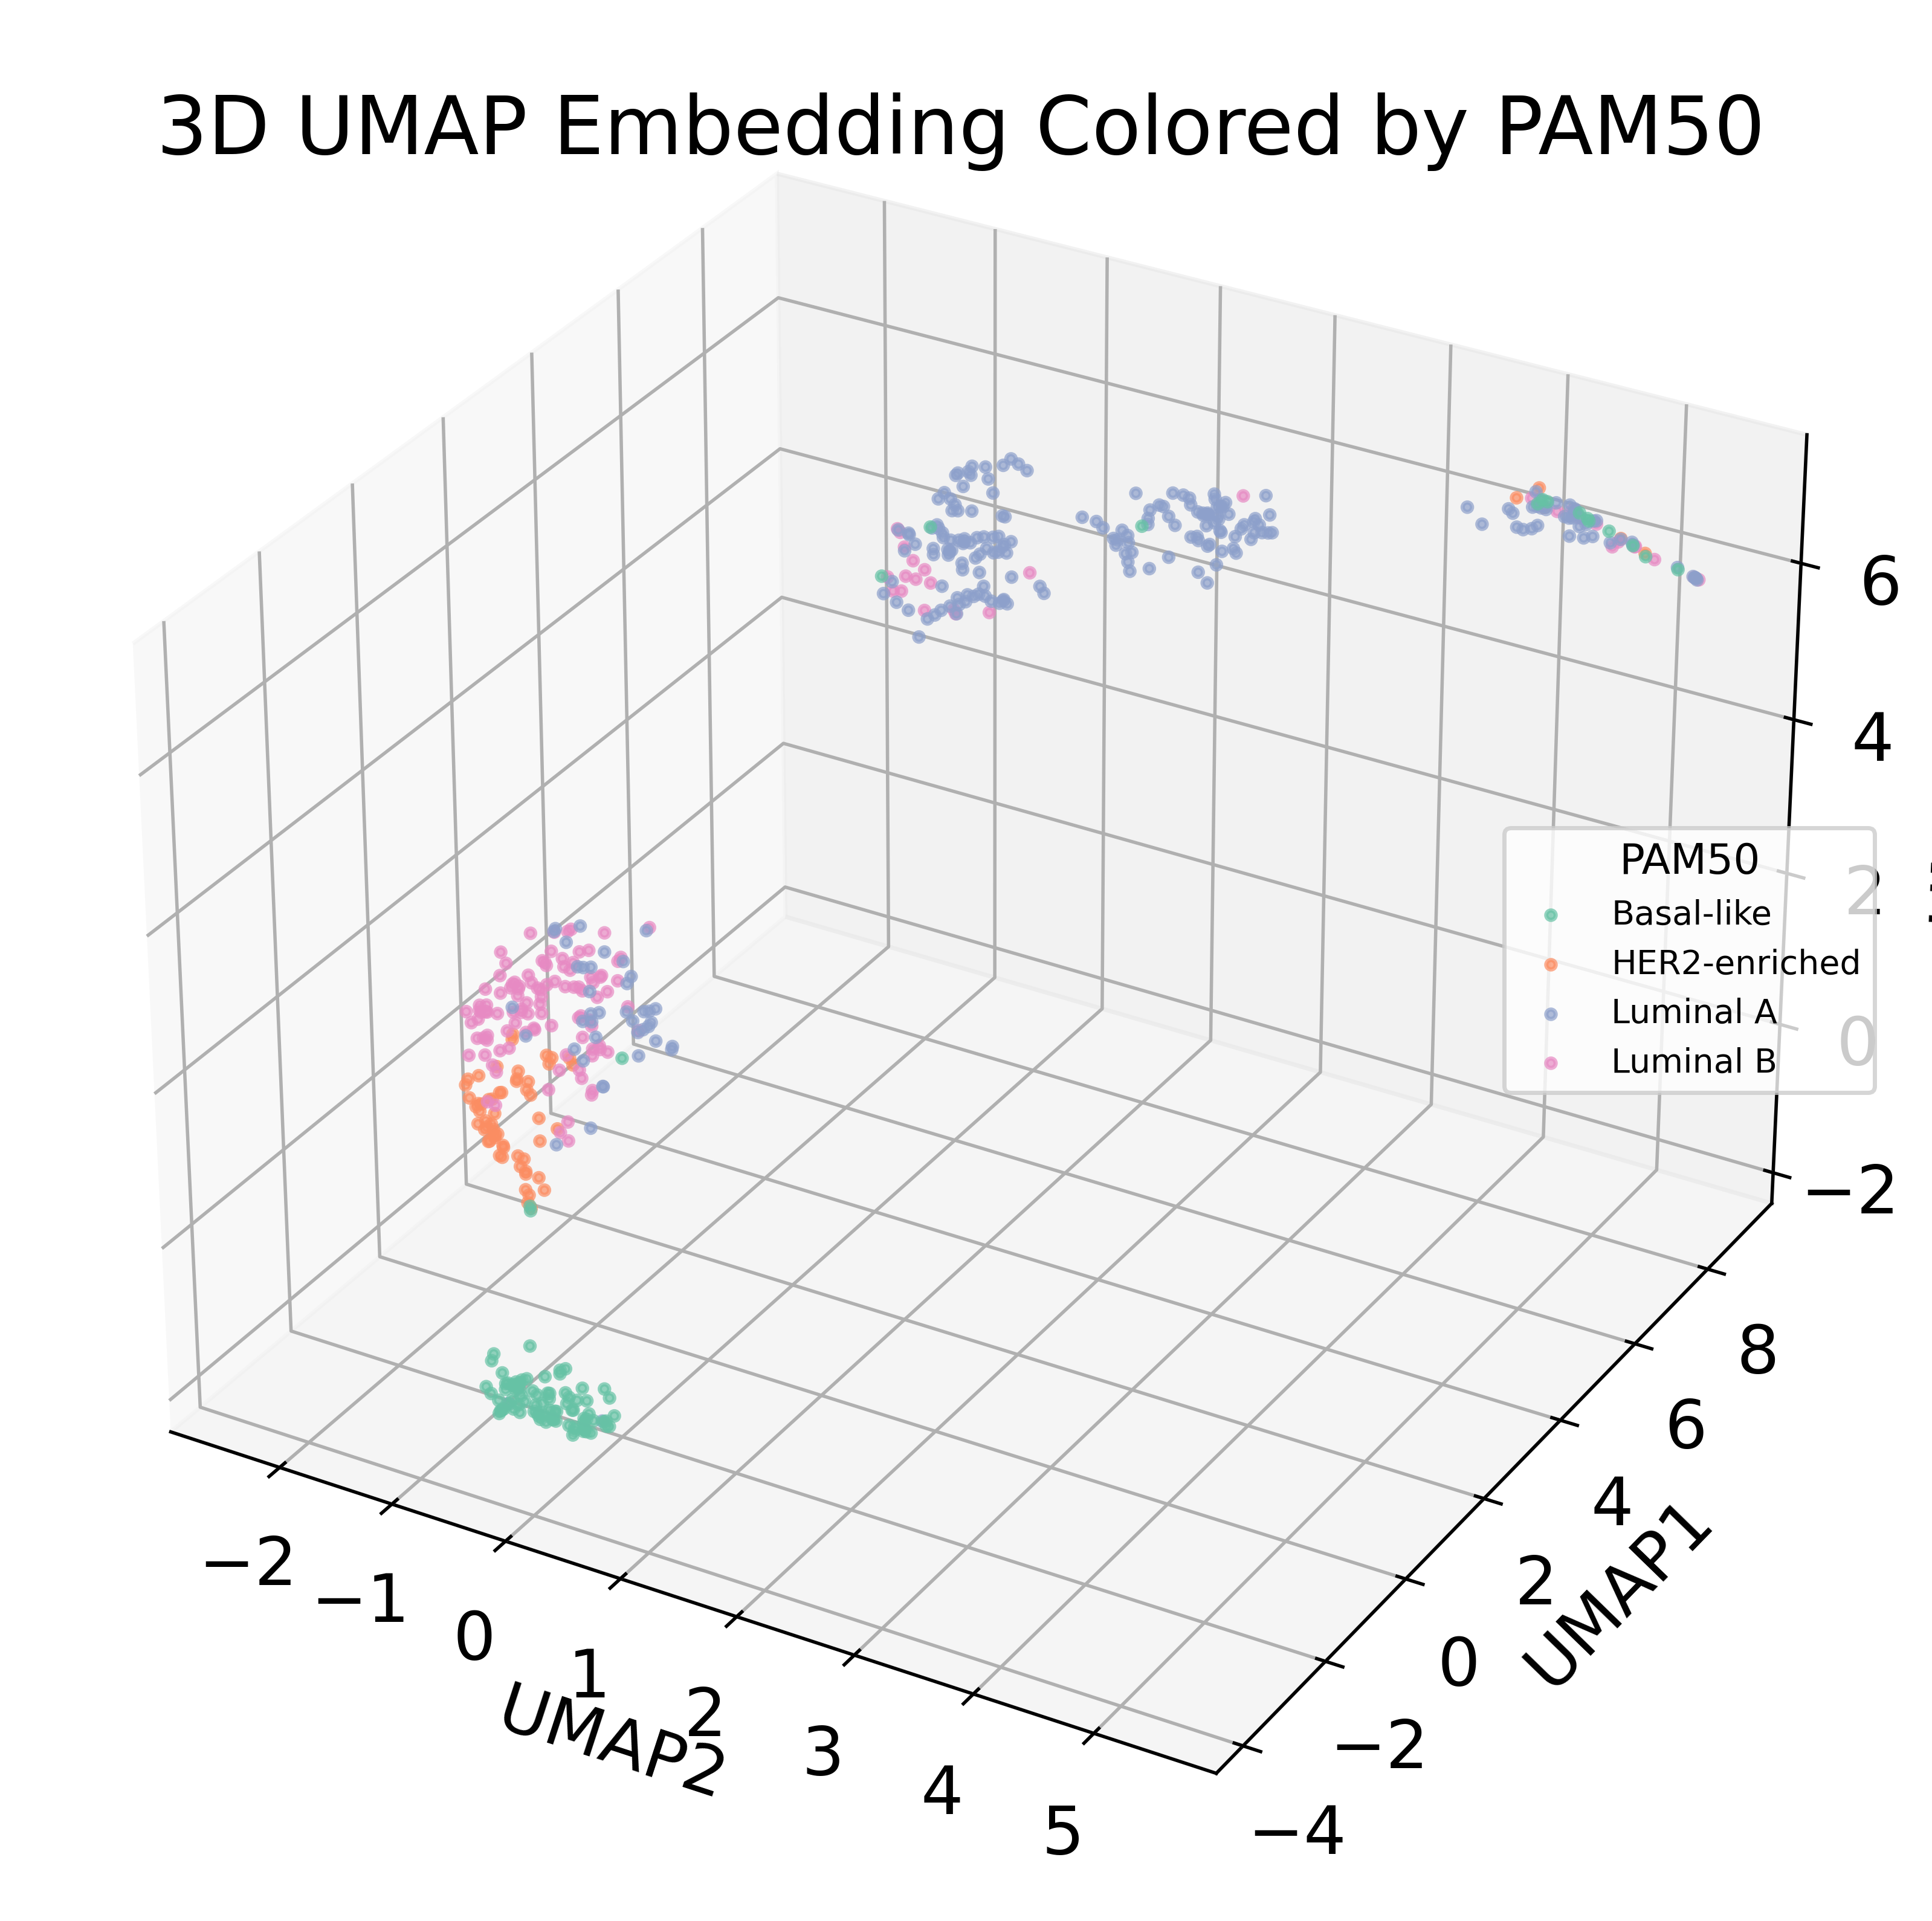

In [94]:
import ast

param_str = best_rows[best_rows["method"] == "UMAP"]["parameters"].iloc[0]
umap_params = ast.literal_eval(param_str)
embedding = umap.UMAP(**umap_params, random_state=seed).fit_transform(X)

# 2) Build DataFrame
cols = ['UMAP1','UMAP2','UMAP3']
df_emb = pd.DataFrame(embedding, columns=cols)
name_to_code = {
    'Basal-like':     0,
    'HER2-enriched':  1,
    'Luminal A':      2,
    'Luminal B':      3,
    'Normal':         4
}
code_to_name = {v: k for k, v in name_to_code.items()}
df_emb["PAM50"] = [code_to_name[c] for c in y_mapped]

# 3) 3D scatter plot
fig = plt.figure(figsize=(10, 8), dpi=500)
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(df_emb["PAM50"])
palette = dict(zip(unique_labels, sns.color_palette("Set2", n_colors=len(unique_labels))))

for label in unique_labels:
    idx = df_emb["PAM50"] == label
    ax.scatter(
        df_emb.loc[idx, "UMAP2"],
        df_emb.loc[idx, "UMAP1"],
        df_emb.loc[idx, "UMAP3"],
        label=label,
        color=palette[label],
        s=5,
        alpha=0.7
    )

ax.set_xlabel("UMAP2")
ax.set_ylabel("UMAP1")
ax.set_zlabel("UMAP3")
ax.set_title("3D UMAP Embedding Colored by PAM50",  y=1)
ax.legend(title="PAM50", loc="center right", fontsize=8, title_fontsize=10)
plt.show()

## 2D embedding

In [95]:
# 1) Maximum average_score per method
best_scores = (
    df_best_parameter_of_each_method_each_clustering.loc[df_best_parameter_of_each_method_each_clustering['n_components'].isin([2])]
    .groupby('method')['average_score']
    .max()
    .reset_index(name='max_average_score')
)
best_scores

# 2) Full best‐row per method
idx = (
    df_best_parameter_of_each_method_each_clustering.loc[df_best_parameter_of_each_method_each_clustering['n_components'].isin([2])]
    .groupby('method')['average_score']
    .idxmax()
)
best_params_per_method = (
    df_best_parameter_of_each_method_each_clustering.loc[df_best_parameter_of_each_method_each_clustering['n_components'].isin([2])]
    .loc[idx]
    .reset_index(drop=True)
)
best_params_per_method

# Restrict to n_components 2 or 3
df23 = df[df['n_components'].isin([2])]

# Boolean mask where each row’s average_score equals the per‐method max within the 2/3 subset
mask = df23['average_score'] == df23.groupby('method')['average_score'].transform('max')

# Select those rows
best_rows = df23[mask]
best_rows

method                                         parameters  n_components  \
3       PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
8       PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
13      PCA  {'n_components': 2, 'svd_solver': 'covariance_...             2   
18      PCA  {'n_components': 2, 'svd_solver': 'randomized'...             2   
23      PCA  {'n_components': 2, 'svd_solver': 'randomized'...             2   
28      PCA  {'n_components': 2, 'svd_solver': 'randomized'...             2   
33      PCA  {'n_components': 2, 'svd_solver': 'full', 'tol...             2   
38      PCA  {'n_components': 2, 'svd_solver': 'full', 'tol...             2   
43      PCA  {'n_components': 2, 'svd_solver': 'full', 'tol...             2   
180     MDS  {'max_iter': 300, 'metric': True, 'n_component...             2   
185     MDS  {'max_iter': 300, 'metric': True, 'n_component...             2   
190     MDS  {'max_iter': 300, 'metric': True, 'n_component...             2   
793   t-SNE  {'early_exaggeration': 12, 'learning_rate': 10...             2   
2598   UMAP  {'init': 'pca', 'metric': 'canberra', 'min_dis...             2   

     clustering  average_score  
3       hdbscan       0.409203  
8       hdbscan       0.409203  
13      hdbscan       0.409203  
18      hdbscan       0.409203  
23      hdbscan       0.409203  
28      hdbscan       0.409203  
33      hdbscan       0.409203  
38      hdbscan       0.409203  
43      hdbscan       0.409203  
180      kmeans       0.374569  
185      kmeans       0.374569  
190      kmeans       0.374569  
793     hdbscan       0.542165  
2598    hdbscan       0.558785

In [96]:
print(best_rows[best_rows["method"] == "UMAP"]["parameters"].iloc[0])

{'init': 'pca', 'metric': 'canberra', 'min_dist': 0.001, 'n_components': 2, 'n_neighbors': 15}


/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


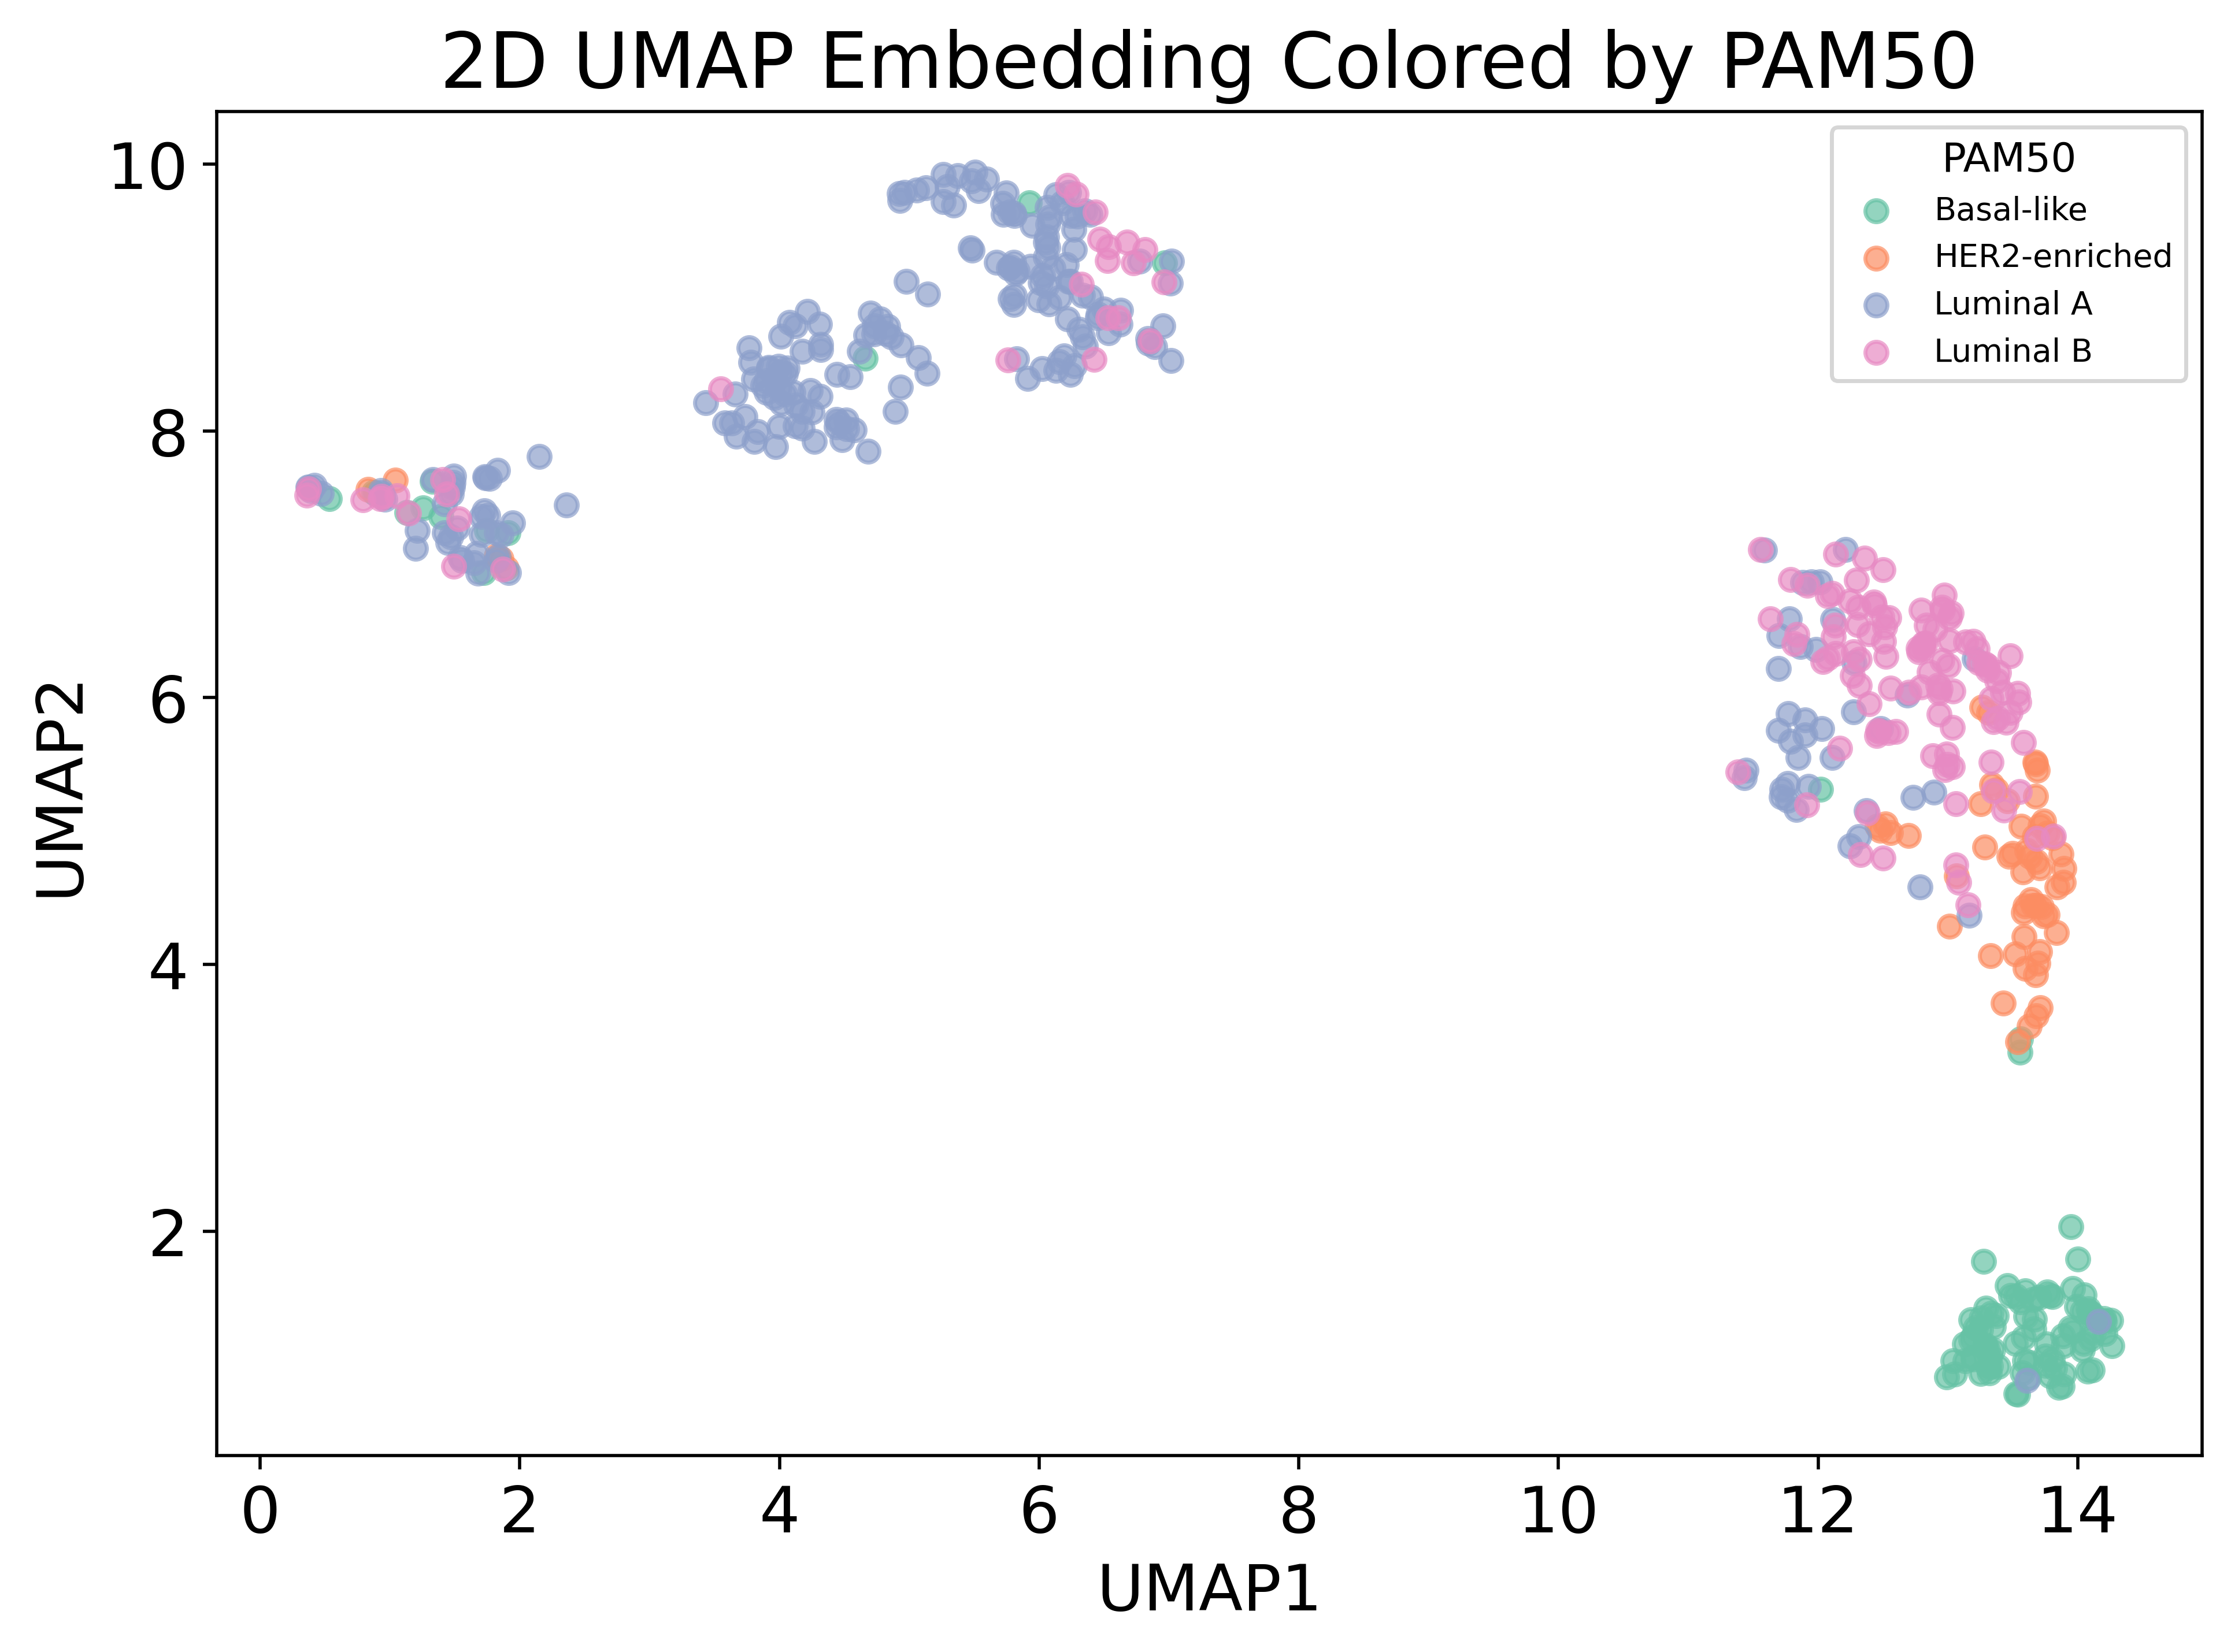

In [97]:
import ast
# 1) Parse best UMAP parameter string
param_str = best_rows[best_rows["method"] == "UMAP"]["parameters"].iloc[0]
umap_params = ast.literal_eval(param_str)

# 2) Compute 2D UMAP embedding
umap_params['n_components'] = 2
embedding = umap.UMAP(**umap_params, random_state=seed).fit_transform(X)

# 3) Build DataFrame
cols = ['UMAP1', 'UMAP2']
df_emb = pd.DataFrame(embedding, columns=cols)
name_to_code = {
    'Basal-like':     0,
    'HER2-enriched':  1,
    'Luminal A':      2,
    'Luminal B':      3,
    'Normal':         4
}
code_to_name = {v: k for k, v in name_to_code.items()}
df_emb["PAM50"] = [code_to_name[c] for c in y_mapped]

# 4) 2D scatter plot
plt.figure(figsize=(8, 6), dpi=500)
unique_labels = np.unique(df_emb["PAM50"])
palette = dict(zip(unique_labels, sns.color_palette("Set2", n_colors=len(unique_labels))))

for label in unique_labels:
    idx = df_emb["PAM50"] == label
    plt.scatter(
        df_emb.loc[idx, "UMAP1"],
        df_emb.loc[idx, "UMAP2"],
        label=label,
        color=palette[label],
        s=30,
        alpha=0.7
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("2D UMAP Embedding Colored by PAM50", y=1)
plt.legend(title="PAM50", loc="best", fontsize=8, title_fontsize=10)
plt.tight_layout()
plt.show()

## Color 2D by metadata

In [98]:
col = "HER2 Final Status"
col = "ER Status"
col = "PR Status"

# 1) Fill NaNs with a sentinel label
filled = merged_df_filtered_df[col].fillna('Not Available')
filled.unique()

array(['Negative', 'Indeterminate', 'Positive',
       'Performed but Not Available', 'Not Performed'], dtype=object)

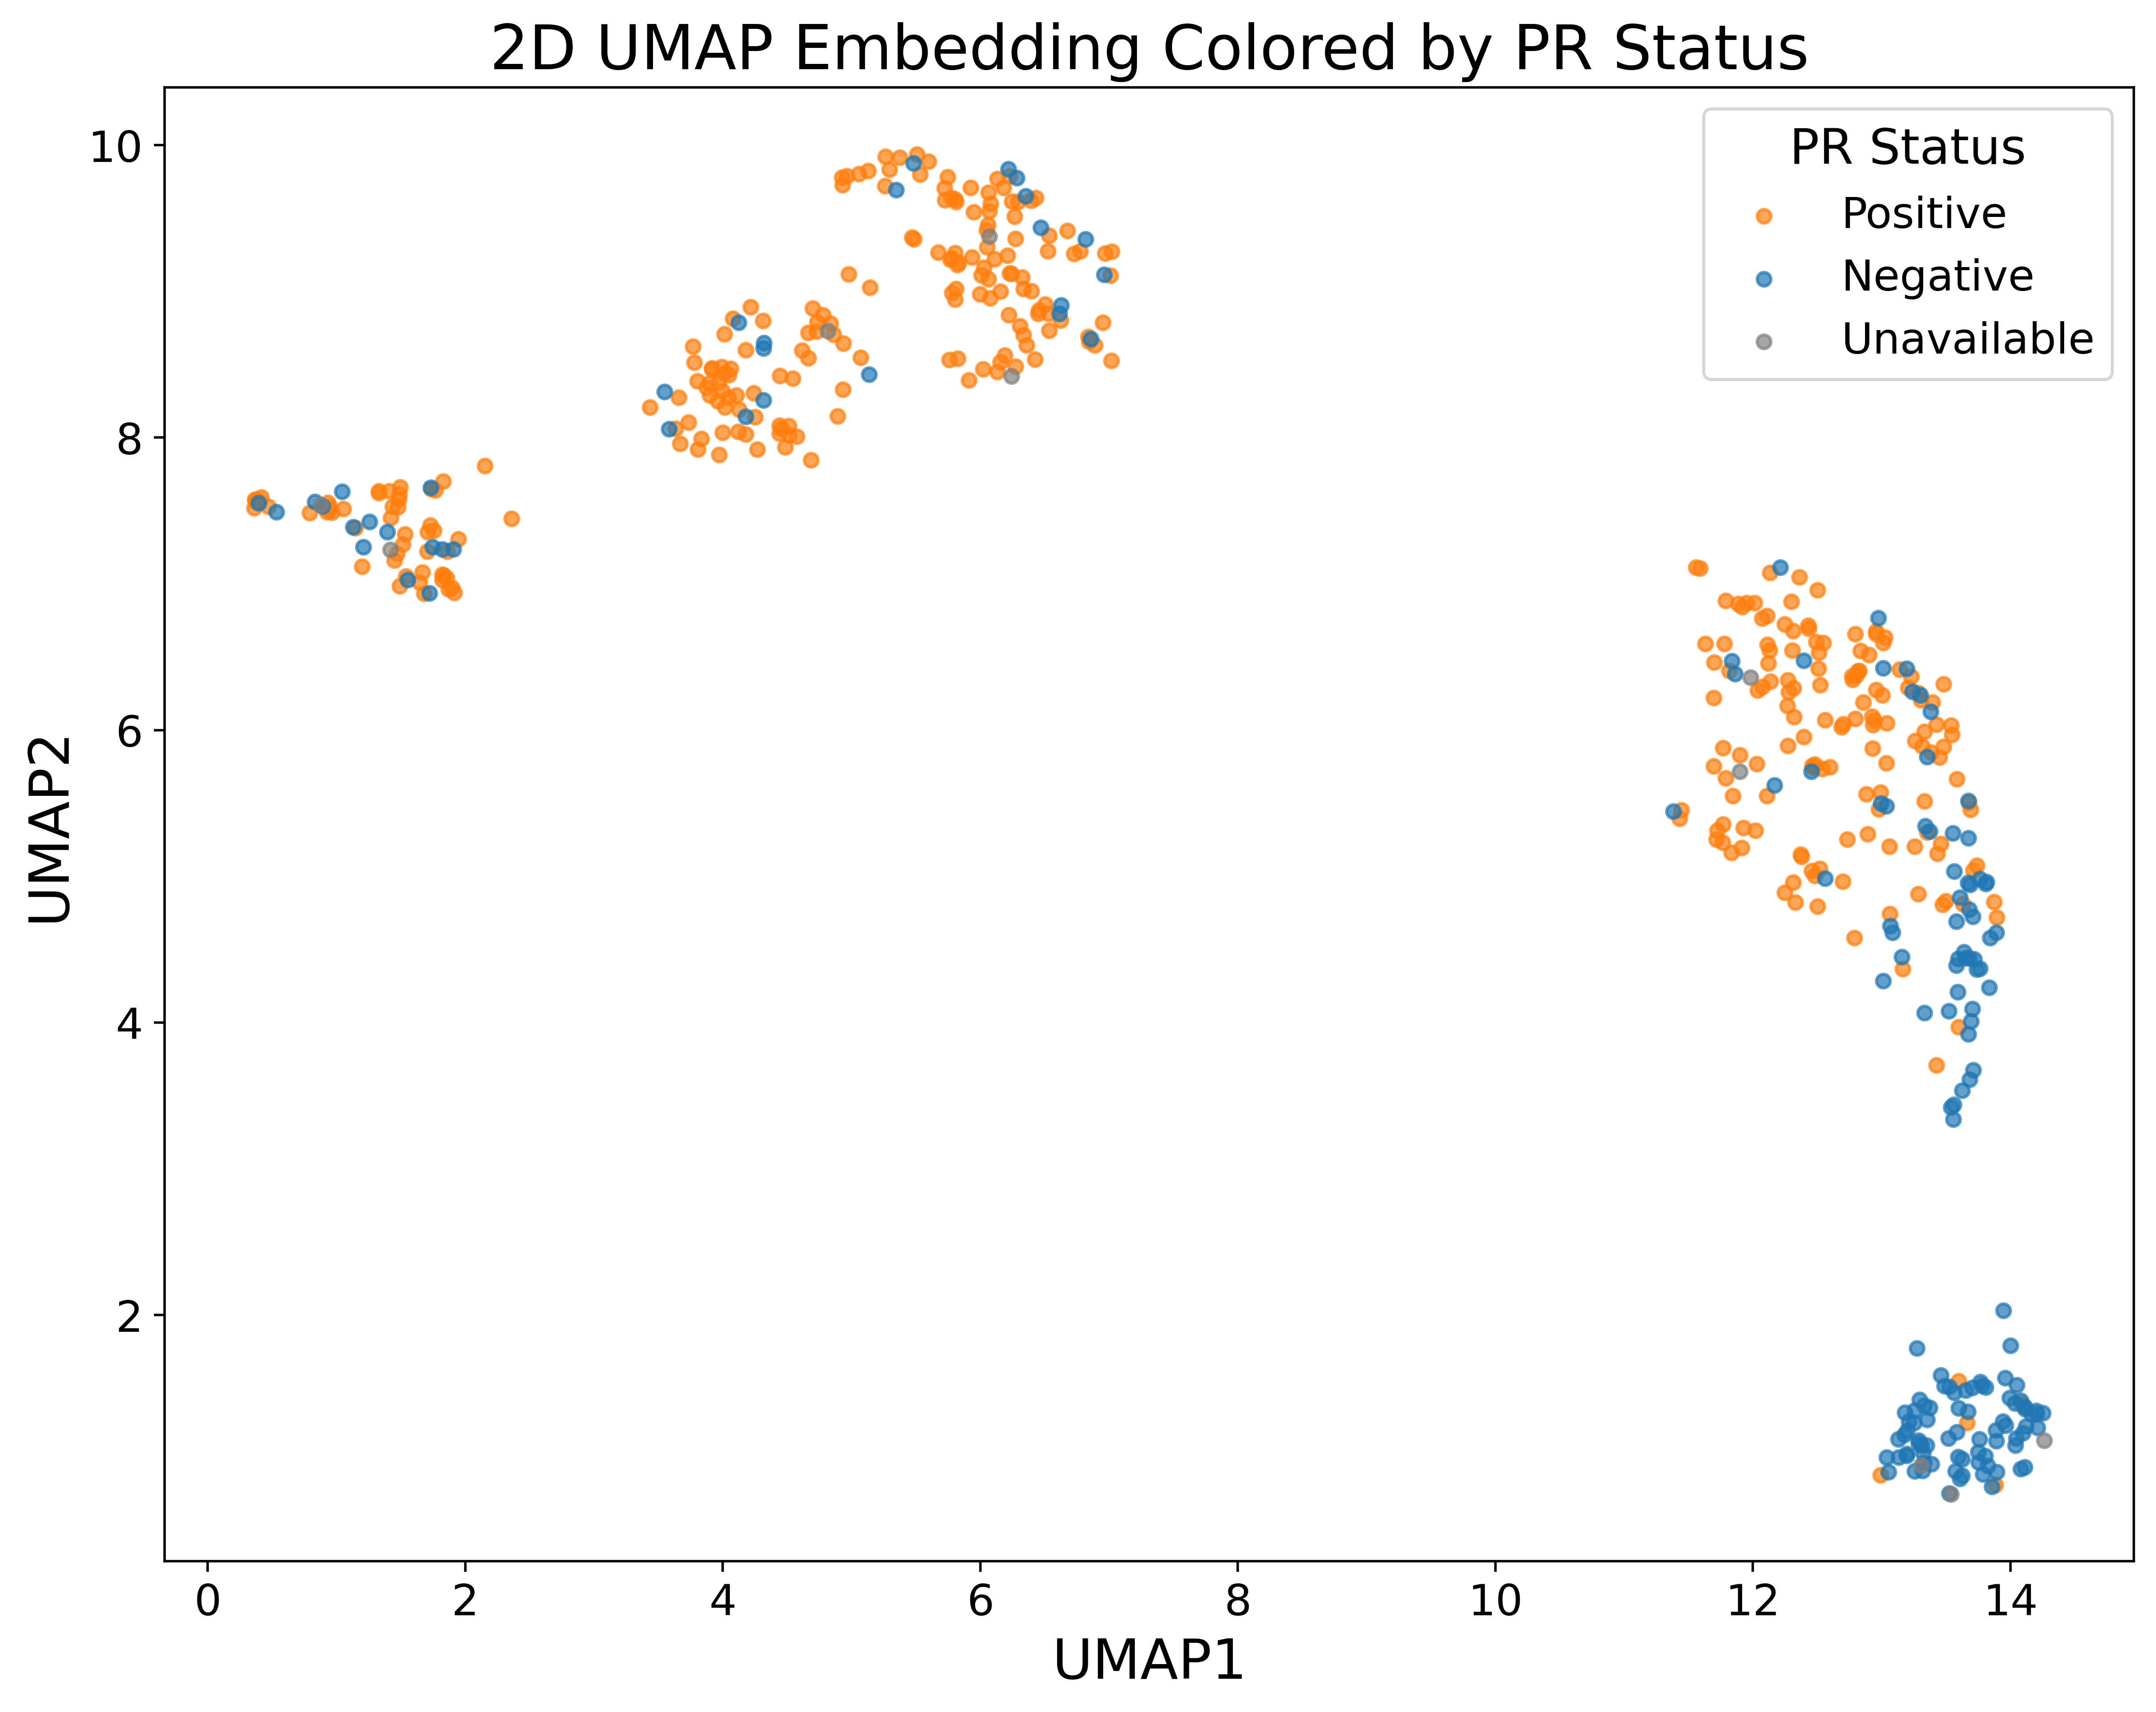

In [99]:
# gender_mapping = {
#     'Positive': 0,
#     'Negative': 1,
#     'Not Available': 2, 'Equivocal':2,
# }

# codes = filled.map(gender_mapping).fillna(2).astype(int)

# # 4) Invert back to names if you want
# gender_code_to_name = {
#     0: 'Positive',
#     1: 'Negative',
#     2: 'Unavailable'
# }


# gender_mapping = {
#     'Positive': 0,
#     'Negative': 1,
#     'Performed but Not Available': 2, 'Not Performed':2, 'Indeterminate': 2,
# }

# codes = filled.map(gender_mapping).fillna(2).astype(int)

# # 4) Invert back to names if you want
# gender_code_to_name = {
#     0: 'Positive',
#     1: 'Negative',
#     2: 'Unavailable'
# }


gender_mapping = {
    'Positive': 0,
    'Negative': 1,
    'Performed but Not Available': 2, 'Not Performed':2, 'Indeterminate': 2,
}

codes = filled.map(gender_mapping).fillna(2).astype(int)

# 4) Invert back to names if you want
gender_code_to_name = {
    0: 'Positive',
    1: 'Negative',
    2: 'Unavailable'
}

labels = codes.map(gender_code_to_name)

# Now `codes` is your numeric array (0/1/2) and `labels` your strings
y_gender_mapped = codes.values
df_emb['GenderLabel'] = labels.values

y_gender_mapped = np.array([gender_mapping[g] for g in filled])
df_emb[col] = [gender_code_to_name[c] for c in y_gender_mapped]

# 3) Plot
plt.rcParams.update({'font.size': 16})

# Mapping and desired legend order
order = [gender_code_to_name[k] for k in sorted(gender_code_to_name)]

# Explicit colors for each label
color_map = {
    'Positive':   'tab:orange',
    'Negative':   'tab:blue',
    'Unavailable': 'grey'
}

# Plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=500)
for label in order:
    mask = df_emb[col] == label
    ax.scatter(
        df_emb.loc[mask, 'UMAP1'],
        df_emb.loc[mask, 'UMAP2'],
        label=label,
        color=color_map[label],
        s=20,
        alpha=0.7
    )

# Formatting
ax.set_xlabel("UMAP1", fontsize=18)
ax.set_ylabel("UMAP2", fontsize=18)
ax.set_title(f"2D UMAP Embedding Colored by {col}", fontsize=20, y=1)
ax.legend(title=col, loc="best", fontsize=14, title_fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

In [100]:
df_embedding = pd.DataFrame(embedding, columns=['Component_1', 'Component_2'])
df_embedding
# df_embedding.to_csv('../output/tables/469_patients_533_samples_no_Normal_like_patients_and_patients_of_two_histological_subtypes_PAM50_genes_robustscaler_4_reduction_methods_parameter_search_5_clustering_methods_default_4_metrics_3D_UMAP_embedding.csv', index=False)

Component_1  Component_2
0      13.306647     1.110117
1      13.623715     0.903986
2      13.886333     1.213356
3      14.111174     0.960308
4      13.309201     0.973633
..           ...          ...
528    12.134384     7.076834
529    12.461209     5.756463
530     0.934777     7.507934
531    13.195405     6.421061
532    12.500381     6.958697

[533 rows x 2 columns]

In [101]:
# import ast
# # 1) Parse best UMAP parameter string
# param_str = best_rows[best_rows["method"] == "UMAP"]["parameters"].iloc[0]
# umap_params = ast.literal_eval(param_str)

# # 2) Compute UMAP embedding
# embedding = umap.UMAP(**umap_params, random_state=seed).fit_transform(X)
# n_dim = embedding.shape[1]

# # 3) Build DataFrame
# name_to_code = {
#     'Basal-like':     0,
#     'HER2-enriched':  1,
#     'Luminal A':      2,
#     'Luminal B':      3,
#     'Normal':         4
# }

# # Invert it:
# code_to_name = {code: name for name, code in name_to_code.items()}

# cols = [f"UMAP{i+1}" for i in range(n_dim)]
# df_emb = pd.DataFrame(embedding, columns=cols)
# df_emb["PAM50"] = [code_to_name[c] for c in y_mapped]

# # 4) Plot with Plotly
# if n_dim == 2:
#     fig = px.scatter(
#         df_emb,
#         x=cols[0],
#         y=cols[1],
#         color="PAM50",
#         title="UMAP Embedding Colored by PAM50",
#         width=700,
#         height=600
#     )
# else:
#     fig = px.scatter_3d(
#         df_emb,
#         x=cols[0],
#         y=cols[1],
#         z=cols[2],
#         color="PAM50",
#         title="UMAP Embedding Colored by PAM50",
#         width=700,
#         height=600,
#     )
#     fig.update_traces(marker=dict(size=3))
#     fig.write_image("/Users/zichenjiang/Downloads/TCGA BRCA BENG 285/469_patients_533_samples_no_Normal_like_patients_and_patients_of_two_histological_subtypes_PAM50_genes_robustscaler_4_reduction_methods_parameter_search_5_clustering_methods_default_4_metrics_best_2D_UMAP.pdf")
# fig.show()

# HDBSCAN clustering of the embedding

In [102]:
# 1) Run HDBSCAN on the existing embedding
# 2) Compute HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
hdb_labels = clusterer.fit_predict(embedding)

# 2) Build DataFrame for Plotly
n_dim = embedding.shape[1]
cols = [f"UMAP{i+1}" for i in range(n_dim)]
df_emb = pd.DataFrame(embedding, columns=cols)
df_emb["HDBSCAN"] = (hdb_labels + 1).astype(str)

# Determine ordered categories
categories = sorted(df_emb['HDBSCAN'].unique(), key=int)

# 3) Plot dynamically in 2D or 3D with ordered legend and custom title
if n_dim == 2:
    fig = px.scatter(
        df_emb,
        x=cols[0],
        y=cols[1],
        color="HDBSCAN",
        category_orders={"HDBSCAN": categories},
        labels={"HDBSCAN": "HDBSCAN Clusters"},
        title="UMAP Embedding Colored by HDBSCAN Clusters",
        width=700,
        height=600
    )
else:
    fig = px.scatter_3d(
        df_emb,
        x=cols[0],
        y=cols[1],
        z=cols[2],
        color="HDBSCAN",
        category_orders={"HDBSCAN": categories},
        labels={"HDBSCAN": "HDBSCAN Clusters"},
        title="UMAP Embedding Colored by HDBSCAN Clusters",
        width=700,
        height=600
    )

# 4) Set marker size small
fig.update_traces(marker=dict(size=3))
# fig.write_image("../output/figures/469_patients_533_samples_no_Normal_like_patients_and_patients_of_two_histological_subtypes_PAM50_genes_robustscaler_4_reduction_methods_parameter_search_5_clustering_methods_default_4_metrics_best_2D_UMAP_HDBSCAN_default.pdf")
fig.show()

/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



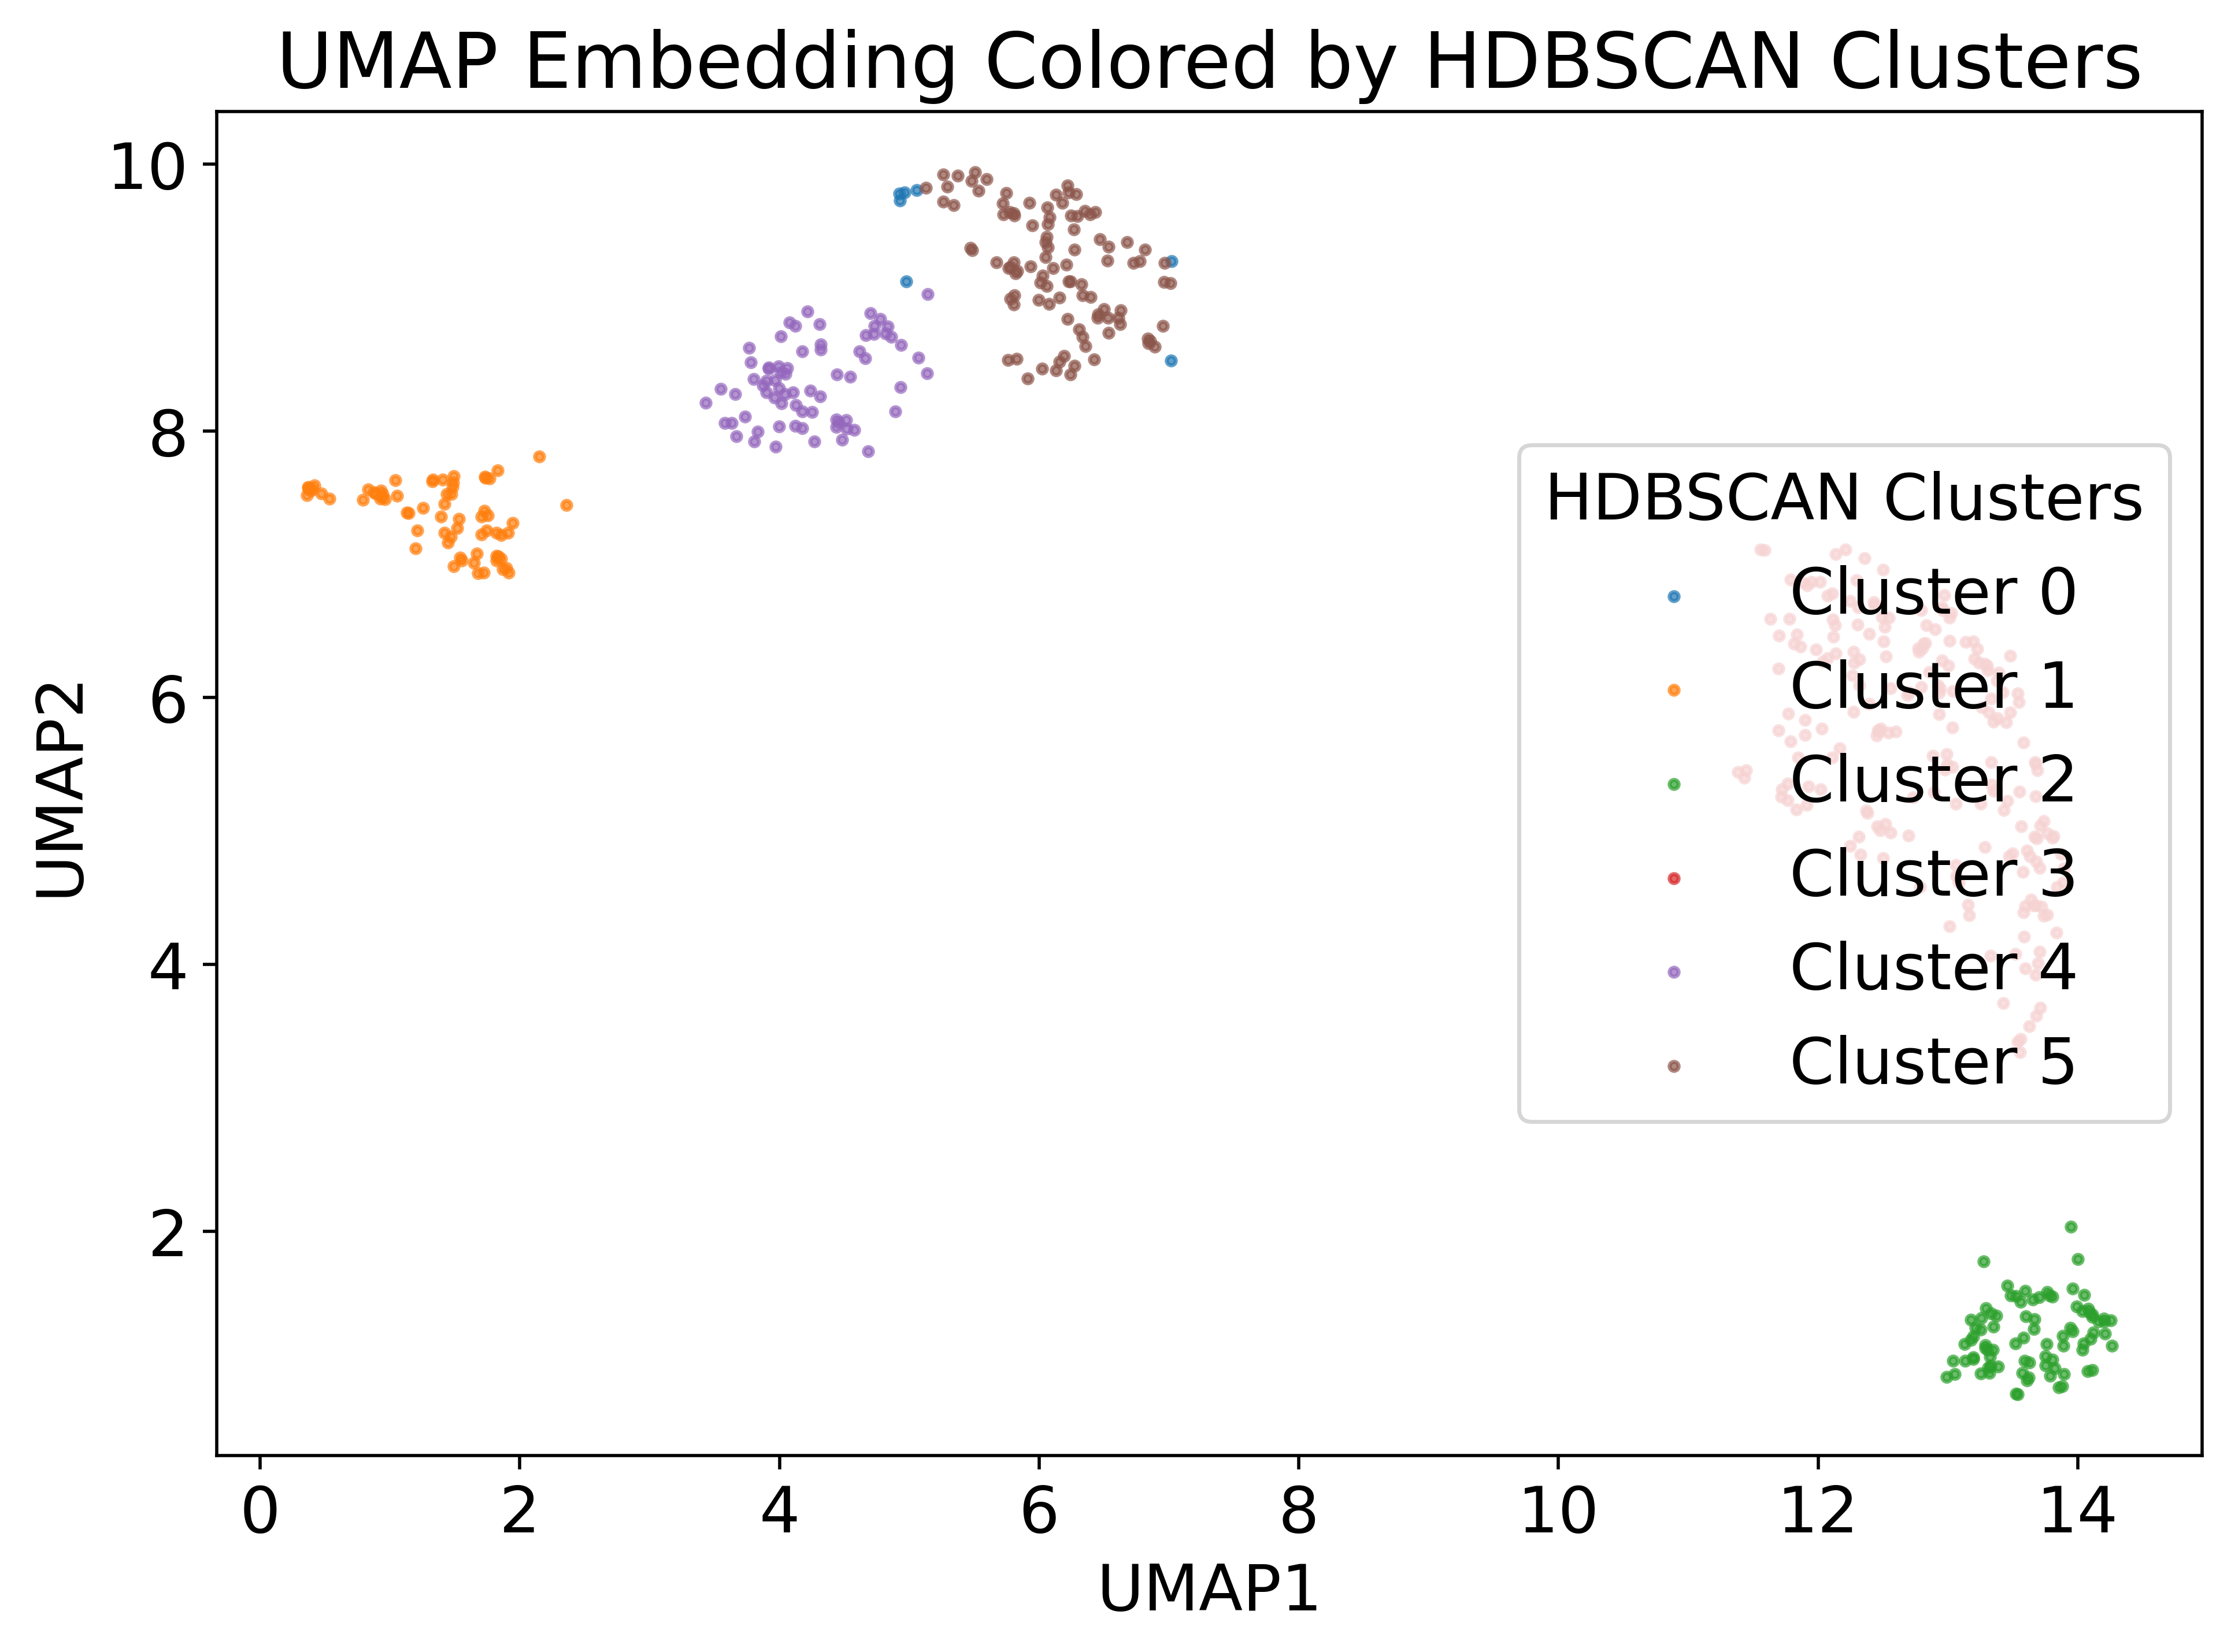

In [103]:
# 1) Run HDBSCAN on the existing embedding
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
hdb_labels = clusterer.fit_predict(embedding) + 1

# 2) Build DataFrame
n_dim = embedding.shape[1]
cols = [f"UMAP{i+1}" for i in range(n_dim)]
df_emb = pd.DataFrame(embedding, columns=cols)
df_emb["HDBSCAN"] = hdb_labels.astype(str)

# 3) Determine ordered categories
categories = sorted(df_emb["HDBSCAN"].unique(), key=int)
palette = dict(zip(categories, sns.color_palette("tab10", n_colors=len(categories))))

# 4) Plot
if n_dim == 2:
    fig, ax = plt.subplots(figsize=(8, 6), dpi=500)
    for cat in categories:
        mask = df_emb["HDBSCAN"] == cat
        ax.scatter(
            df_emb.loc[mask, "UMAP1"],
            df_emb.loc[mask, "UMAP2"],
            label=f"Cluster {cat}",
            color=palette[cat],
            s=5,
            alpha=0.7
        )
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
else:
    fig = plt.figure(figsize=(8, 6), dpi=500)
    ax = fig.add_subplot(111, projection='3d')
    for cat in categories:
        mask = df_emb["HDBSCAN"] == cat
        ax.scatter(
            df_emb.loc[mask, "UMAP2"],
            df_emb.loc[mask, "UMAP1"],
            df_emb.loc[mask, "UMAP3"],
            label=f"Cluster {cat}",
            color=palette[cat],
            s=5,
            alpha=0.7
        )
    ax.set_xlabel("UMAP2")
    ax.set_ylabel("UMAP1")
    ax.set_zlabel("UMAP3")

ax.set_title("UMAP Embedding Colored by HDBSCAN Clusters")
ax.legend(title="HDBSCAN Clusters", loc='center right')
plt.tight_layout()
plt.show()

# HDBSCAN clustering look better with a different parameter

In [104]:
# 1) Run HDBSCAN on the existing embedding
clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
hdb_labels = clusterer.fit_predict(embedding)

# 2) Build DataFrame for Plotly
n_dim = embedding.shape[1]
cols = [f"UMAP{i+1}" for i in range(n_dim)]
df_emb = pd.DataFrame(embedding, columns=cols)
df_emb["HDBSCAN"] = (hdb_labels + 1).astype(str)

# Determine ordered categories
categories = sorted(df_emb['HDBSCAN'].unique(), key=int)

# 3) Plot dynamically in 2D or 3D with ordered legend and custom title
if n_dim == 2:
    fig = px.scatter(
        df_emb,
        x=cols[0],
        y=cols[1],
        color="HDBSCAN",
        category_orders={"HDBSCAN": categories},
        labels={"HDBSCAN": "HDBSCAN Clusters"},
        title="UMAP Embedding Colored by HDBSCAN Clusters",
        width=700,
        height=600
    )
else:
    fig = px.scatter_3d(
        df_emb,
        x=cols[0],
        y=cols[1],
        z=cols[2],
        color="HDBSCAN",
        category_orders={"HDBSCAN": categories},
        labels={"HDBSCAN": "HDBSCAN Clusters"},
        title="UMAP Embedding Colored by HDBSCAN Clusters",
        width=700,
        height=600
    )

# 4) Set marker size small
fig.update_traces(marker=dict(size=3))
# fig.write_image("../output/figures/469_patients_533_samples_no_Normal_like_patients_and_patients_of_two_histological_subtypes_PAM50_genes_robustscaler_4_reduction_methods_parameter_search_5_clustering_methods_default_4_metrics_best_2D_UMAP_HDBSCAN_default.pdf")
fig.show()

/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/zichenjiang/miniconda3/envs/umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [105]:
df_emb

UMAP1     UMAP2 HDBSCAN
0    13.306647  1.110117       2
1    13.623715  0.903986       2
2    13.886333  1.213356       2
3    14.111174  0.960308       2
4    13.309201  0.973633       2
..         ...       ...     ...
528  12.134384  7.076834       3
529  12.461209  5.756463       3
530   0.934777  7.507934       1
531  13.195405  6.421061       3
532  12.500381  6.958697       3

[533 rows x 3 columns]